<font size="6"> <div class="alert alert-block alert-info"> Ethereum Time Series Analysis and Predictions in Python </div> </font>
  
  <font size="4"> **João Oliveira | jbboa@iscte-iul.pt** </font>
  

   In this notebook we will go over:
   
   * Creation of important functions that will be used later.
   * Data cleaning and preprocessing.
   * Exploratory Data Analysis (EDA) to gain insights into the Ethereum time series data.
   * Modelling and generation of test set predictions for one hundred (100) Ethereum Close Prices values.

## Import libraries

**For data manipulation**

In [2]:
import os
import pandas_datareader.data as web # to get the data directly from FRED
import numpy as np
import pandas as pd
import math
import itertools
import datetime as dt # permite manipular as datas e o tempo (hora)
from datetime import datetime, date, time
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset
import time
from numpy.random import seed
from pylab import rcParams
from scipy import stats
import arch

from collections import Counter

from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#pd.options.display.max_rows = None

#yf.pdr_override()

# Ignore harmless warnings
import warnings
#warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning, module='sklearn')

**For data visualization**

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, NullFormatter

import seaborn as sns
#sns.set_palette('plasma')
sns.color_palette("bright")
plt.style.use("seaborn-whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
# plt.style.available

import plotly.express as px
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import month_plot,quarter_plot, plot_acf, plot_pacf
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

**For data modelling**

In [4]:
# Stationarity and Unit root tests
import statsmodels as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox ##Ljung-Box test, autocorrelations up to a specified lag are zero
from statsmodels.tsa.seasonal import seasonal_decompose   ### seasonal decomposition
 
# For ARMA / ARIMA / SARIMA / SARIMAX Models
from statsmodels.tsa.arima_model import ARIMA   ### ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm    ##### auto-arima

# model metrics
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

# For RNN and LSTM models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import load_model, Model, Sequential
from keras.layers import GRU, Dense, LSTM, Dropout, Reshape
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import get_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from keras.optimizers import Adam, Adadelta, Adagrad, Adam, Adamax, Nadam, RMSprop, SGD
from keras.utils import plot_model
from keras import regularizers

# For Facebook prophet model
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

## Creating functions

In [5]:
def teste_estacionaridade(serie):
    """
    Description: Function to test the stationarity of a given time series using the Augmented Dickey-Fuller (ADF),
    Phillips-Perron (PP), and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests.

    Inputs:
        - serie (numpy array or pandas Series): The time series data to be tested for stationarity..

    Outputs:
        - Prints if the given serie is or not stationary for all three tests.
    """
    ### ADF test (time series is stationary)
    adf1 = adfuller(serie, regression='c', autolag='AIC')
    print('Resultados da aplicação do teste Augmented Dickey-Fuller')
    if adf1[1] < 0.05:
        print('Rejeito H0, não tem raiz unitária -> Estacionária')
    else:
        print('Não rejeito H0, tem raiz unitária -> Não estacionária')

    ### PP test (time series is stationary)
    # Perform the Phillips-Perron test
    pp2 = PhillipsPerron(serie, trend="ct")
    print('\nResultados da aplicação do teste Phillips-Perron')
    if pp2.pvalue < 0.05:
        print('Rejeito H0, não tem raiz unitária -> Estacionária')
    else:
        print('Não rejeito H0, tem raiz unitária -> Não estacionária')

    # Assuming your time series data is stored in the variable 'ts'

    # Perform the KPSS test
    kpss2 = kpss(serie)

    print('\nResultados da aplicação do teste Kwiatkowski–Phillips–Schmidt–Shin')
    if kpss2[1] > 0.05:
        print('Rejeito H0, não tem raiz unitária -> Estacionária')
    else:
        print('Não rejeito H0, tem raiz unitária -> Não estacionária')

    return

In [6]:
def erros(model_name, test, predictions):
    """
    Description: Function to calculate the RMSE, R-squared (R^2), MAPE, and MAE of a given model.

    Inputs:
        - model_name (string): The name or identifier of the model being evaluated.
        - test (numpy array or pandas Series): The actual values or ground truth of the target variable.
        - predictions (numpy array or pandas Series): The predicted values of the target variable generated by the model.

    Outputs:
        - Returns a list containing the RMSE, R-squared (R^2), MAPE, and MAE results.
    """
    rmse_result = np.sqrt(mean_squared_error(test, predictions))
    print(f'{model_name} RMSE Error: {rmse_result:0.10f}')

    mae_result = mean_absolute_error(test, predictions)
    print(f'{model_name} MAE Error: {mae_result:0.10f}')

    # Calculate the absolute errors
    errors = test - predictions

    # Calculate the percentage errors, handling zero values
    percentage_errors = np.abs(errors / test)

    # Calculate the mean absolute percentage error (MAPE)
    mape_result = np.mean(np.abs(percentage_errors)) * 100
    print(f'{model_name} MAPE Error: {mape_result:0.2f}')

    r2_result = r2_score(test, predictions)
    print(f'{model_name} R^2 Score: {r2_result:0.10f}')
    
    return [rmse_result, mae_result, mape_result, r2_result]

In [7]:
def erros(model_name, test, predictions):
    """
    Description: Function to calculate the RMSE, R-squared (R^2), MAPE, and MAE of a given model.

    Inputs:
        - model_name (string): The name or identifier of the model being evaluated.
        - test (numpy array or pandas Series): The actual values or ground truth of the target variable.
        - predictions (numpy array or pandas Series): The predicted values of the target variable generated by the model.

    Outputs:
        - Returns a list containing the RMSE, R-squared (R^2), MAPE, and MAE results.
    """
    rmse_result = rmse(test, predictions)
    print(f'{model_name} RMSE Error: {rmse_result:11.10}')

    mae_result = mean_absolute_error(test, predictions)
    print(f'{model_name} MAE Error: {mae_result:11.10}')

    # Calculate the absolute errors
    errors = test - predictions

    # Calculate the percentage errors, handling zero values
    percentage_errors = np.abs(errors / test)

    # Calculate the mean absolute percentage error (MAPE)
    mape_result = np.mean(np.abs(percentage_errors)) * 100
    print(f'{model_name} MAPE Error: {mape_result:11.10}')

    r2_result = r2_score(test, predictions)
    print(f'{model_name} R^2 Score: {r2_result:11.10}')
    
    return [rmse_result, mae_result, mape_result, r2_result]

In [8]:
def create_lstm_model(num_layers, num_units, activation, optimizer, learning_rate):
    """
    Description: This function creates an LSTM model for time series forecasting. 
    The model architecture is defined by the number of layers, number of units in each layer, activation function, optimizer, and learning rate.

    Inputs:
        - num_layers (integer): The number of LSTM layers in the model.
        - num_units (integer): The number of units/neurons in each LSTM layer.
        - activation (string): The activation function to be used in the LSTM layers.
        - optimizer (string): The optimizer algorithm for model training, either 'adam' or 'rmsprop'.
        - learning_rate (float): The learning rate for the optimizer.

    Outputs:
        - Returns an LSTM model with the specified architecture.
    """
    if optimizer == 'adam':
        opt = Adam(lr=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(lr=learning_rate)
    else:
        raise ValueError('Invalid optimizer')
        
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(num_units, input_shape=(X_TRAIN.shape[1], 1), activation=activation, return_sequences=True))
        elif i == num_layers - 1: # adicionar nova camada oculta à rede
            model.add(LSTM(num_units, activation=activation))
        else:
            model.add(LSTM(num_units, activation=activation, return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=opt)
    return model

## Loading the Ethereum dataset directly from FRED

In [9]:
data_name = 'CBETHUSD'

start = datetime(2016, 5, 18)
end = datetime(2023, 6, 11)

eth = web.DataReader(data_name, data_source='fred', start=start, end=end)
eth.head(5)

,CBETHUSD
DATE,
2016-05-18,13.18
2016-05-19,14.90
2016-05-20,14.17
2016-05-21,NaN
2016-05-22,NaN


In [10]:
eth = eth.rename(columns={'CBETHUSD': 'Ethereum_Prices'})

#### Observe if the data was imported correctly and check if there are ary missing/null values

In [10]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2581 entries, 2016-05-18 to 2023-06-11
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ethereum_Prices  2578 non-null   float64
dtypes: float64(1)
memory usage: 40.3 KB


#### Conclusões/Key takeaways das primeiras informações sobre o dataset

- **Dataset Information**: The DataFrame contains a single column named "Ethereum_Prices" with a total of 2,581 entries. The index of the DataFrame is a DatetimeIndex, indicating that the data is time-series data spanning from 2016-05-18 to 2023-06-11.

- **Missing Values**: The "Ethereum_Prices" column has a non-null count of 2,578, which means there are three missing values in the dataset.

- **Data Type**: The values in the "Ethereum_Prices" column are of type float64, indicating that they represent numerical values with decimal points.

- **Memory Usage**: The DataFrame occupies a memory space of approximately 40.3 KB.

#### Null values observation and treatment/imputation

In [11]:
missing_rows = eth[eth['Ethereum_Prices'].isna()]
print(missing_rows)

            Ethereum_Prices
DATE                       
2016-05-21              NaN
2016-05-22              NaN
2020-09-04              NaN


In [12]:
missing_dates = eth[eth['Ethereum_Prices'].isna()].index
are_all_weekends = all(date.weekday() >= 5 for date in missing_dates)
print(are_all_weekends)

False


In [13]:
# Create separate dataframes with different imputation methods
meaninput = eth.copy().fillna(eth['Ethereum_Prices'].mean())
medianinput = eth.copy().fillna(eth['Ethereum_Prices'].median())
linearinput = eth.copy().interpolate(method='linear')
ffillinput = eth.copy().fillna(method='ffill')

# Create a list of dataframes
dfs = [("without any imputation/original", eth),
       ("with mean inputation of missing values", meaninput), 
       ("with median input", medianinput), 
       ("with linear interploation inputation of missing values", linearinput), 
       ("with forward fill inputation of missing values", ffillinput)]

**Choosing the best input method utilizing descriptive statistics**

In [14]:
for name, df in dfs:
    print(f"Descriptive Statistics of Ethereum Prices {name}:")
    print(df.describe().T)
    print()

Descriptive Statistics of Ethereum Prices without any imputation/original:
                  count        mean          std   min      25%     50%  \
Ethereum_Prices  2578.0  952.449189  1115.976132  6.75  170.165  362.75   

                       75%      max  
Ethereum_Prices  1593.9525  4805.95  

Descriptive Statistics of Ethereum Prices with mean inputation of missing values:
                  count        mean         std   min     25%     50%  \
Ethereum_Prices  2581.0  952.449189  1115.32712  6.75  170.18  364.62   

                     75%      max  
Ethereum_Prices  1593.93  4805.95  

Descriptive Statistics of Ethereum Prices with median input:
                  count        mean          std   min     25%     50%  \
Ethereum_Prices  2581.0  951.763758  1115.508166  6.75  170.18  362.75   

                     75%      max  
Ethereum_Prices  1593.93  4805.95  

Descriptive Statistics of Ethereum Prices with linear interploation inputation of missing values:
              

#### Conclusões/Key takeaways/ Avaliação dos diversos tipos de imputação utilizados tendo por base os originais

- **Imputation Methods Evaluation**: Standard deviation lowered a lot when compared to that of the original data. Not ideal since the variation in Ethereum prices is crucial for analysis.

- **Median Imputation**: Preserves the median value and is robust to outliers - Provides similar results to the original data for mean, min, max, and percentiles, with slight differences in standard deviation.

- **Linear Interpolation Imputation**: Fills missing values by estimating them based on surrounding data points - Provides results close to the original data for mean, min, max, and percentiles, with slight differences in standard deviation. Best used when there exists a  linear relationship between the missing values and the surrounding data.

- **Forward Fill Imputation**: Fills missing values with the last observed value - Provides similar results to the original data for mean, min, max, and percentiles, with slight differences in standard deviation. Suitable since trends or persistence in the data are to be found.

Therefore, the forward fill imputation method will be utilized as it was considered the most appropriate.

In [11]:
# fill dataframe utilizing the method that was considered to be the best
eth = eth.fillna(method='ffill')
print(eth.head(5))

            Ethereum_Prices
DATE                       
2016-05-18            13.18
2016-05-19            14.90
2016-05-20            14.17
2016-05-21            14.17
2016-05-22            14.17


In [12]:
missing_rows = eth[eth['Ethereum_Prices'].isna()]
print(missing_rows)

Empty DataFrame
Columns: [Ethereum_Prices]
Index: []


## Exploratory Data Analysis - EDA

#### Descriptive Statistics

In [17]:
eth.describe().T

,count,mean,std,min,25%,50%,75%,max
Ethereum_Prices,2581.0,951.501639,1115.688873,6.75,170.16,361.51,1593.93,4805.95


In [18]:
# Calculate Kurtosis and Skewness
kurtosis = stats.kurtosis(eth['Ethereum_Prices'])
skewness = stats.skew(eth['Ethereum_Prices'])

print(f'Kurtosis: {kurtosis}')
print(f'Skewness: {skewness}')

Kurtosis: 1.0320626755560944
Skewness: 1.3816951807224065


#### Observe time-series distribution with an histogram

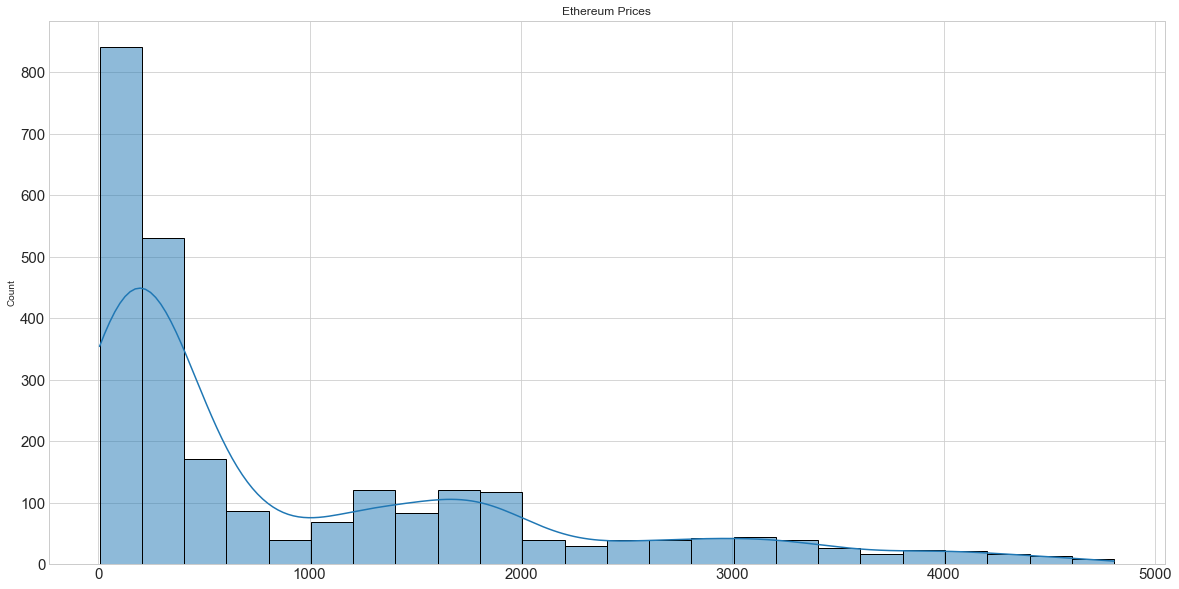

In [19]:
# Set the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# Create subplots
fig, ax = plt.subplots(1, 1)

# Plot histogram with KDE
sns.histplot(eth['Ethereum_Prices'], kde=True, ax=ax)

# Set the title and labels
ax.set_title('Ethereum Prices', fontsize=12)
ax.set_xlabel('')

# Show the plot
plt.show()

#### Utilizing Tukey´s fences to try to observe outliers

In [20]:
# Create an empty dataframe to store all the outliers
all_outliers = pd.DataFrame()

# Calculate the IQR and Tukey's fences for the column
q1 = np.percentile(eth['Ethereum_Prices'], 25)
q3 = np.percentile(eth['Ethereum_Prices'], 75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# Detect the outliers in the column
outliers = eth[(eth['Ethereum_Prices'] < lower_fence) | (eth['Ethereum_Prices'] > upper_fence)]

# Append the outliers to the all_outliers dataframe
all_outliers = pd.concat([all_outliers, outliers], axis=0)

# Print the number of outliers in the column
print(f'Number of outliers in Ethereum_Prices: {len(outliers)}')

Number of outliers in Ethereum_Prices: 92


In [21]:
outliers.head()

,Ethereum_Prices
DATE,
2021-05-08,3914.68
2021-05-09,3927.47
2021-05-10,3946.96
2021-05-11,4172.50
2021-05-12,3800.24


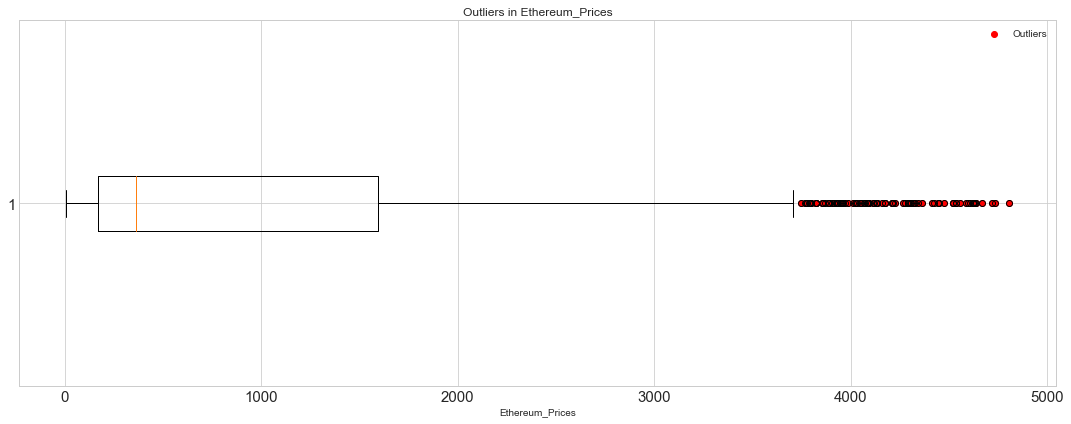

In [22]:
# Define the number of rows and columns for the subplots
nrows = 1
ncols = 1

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))

# Calculate the IQR and Tukey's fences for the column
q1 = np.percentile(eth['Ethereum_Prices'], 25)
q3 = np.percentile(eth['Ethereum_Prices'], 75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# Detect the outliers in the column
outliers = eth[(eth['Ethereum_Prices'] < lower_fence) | (eth['Ethereum_Prices'] > upper_fence)]

# Set the current subplot
ax = axes

# Create the boxplot
ax.boxplot(eth['Ethereum_Prices'], vert=False)
ax.scatter(outliers['Ethereum_Prices'], [1] * len(outliers), color='red', label='Outliers')
ax.set_xlabel('Ethereum_Prices')
ax.set_title('Outliers in Ethereum_Prices')
ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

#### Observe time-series components - Trend, Seasonality and Residuals

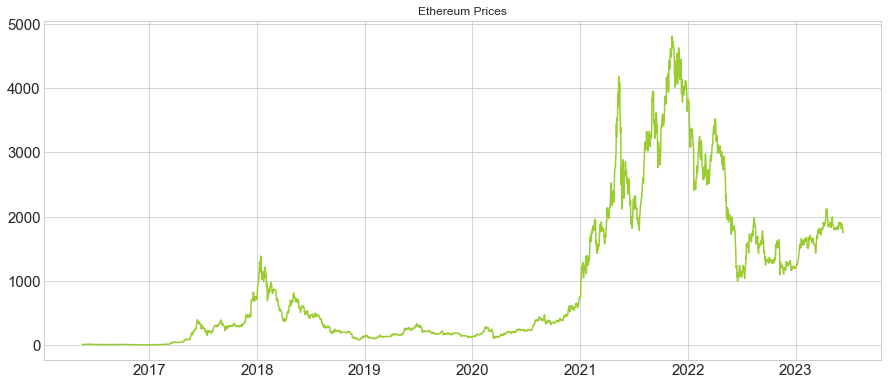

In [23]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

# Plotting the target variable (larger size)
ax_target = fig.add_subplot(gs[0, :])
ax_target.plot(eth['Ethereum_Prices'], color="yellowgreen")
ax_target.set_title('Ethereum Prices')

# Adjust spacing between subplots
gs.update(wspace=0.2, hspace=0.4)

# Display the plots
plt.show()

<Figure size 1080x1080 with 0 Axes>

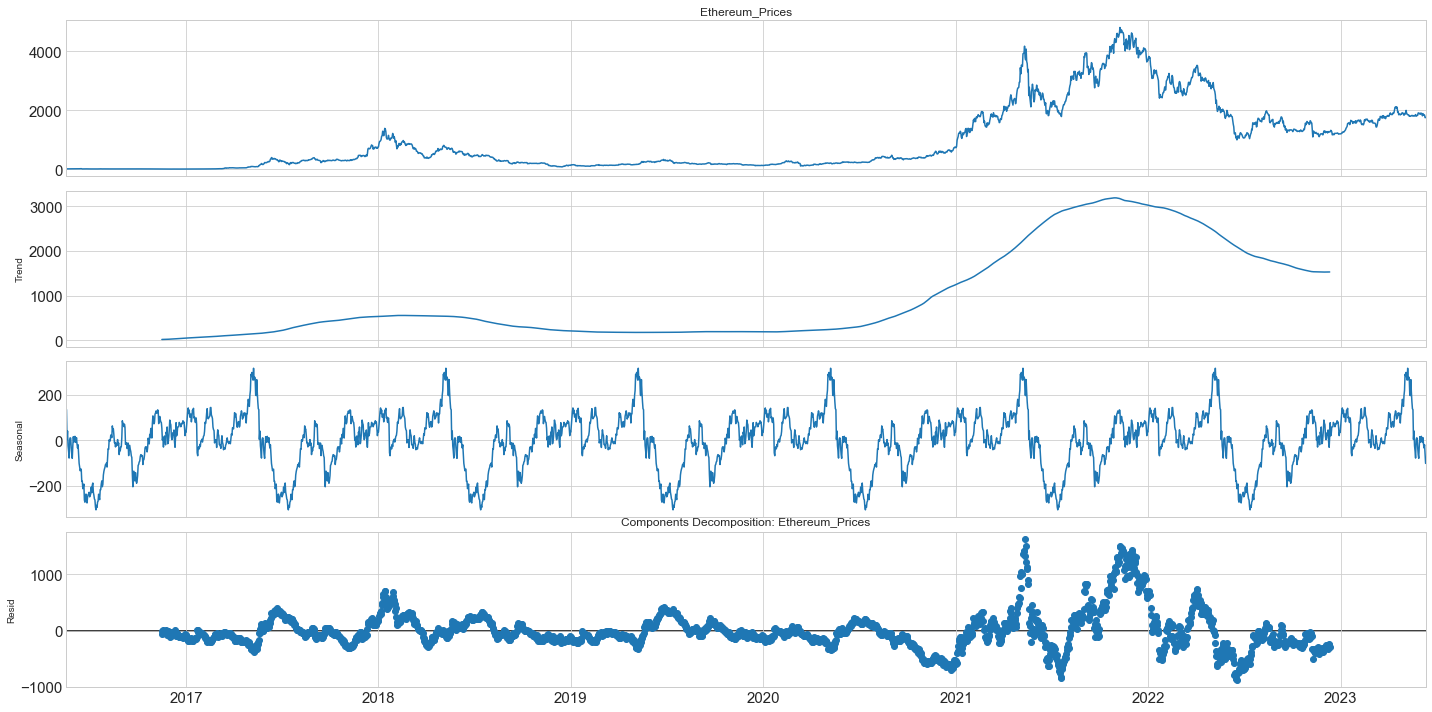

In [24]:
# Perform seasonal decomposition
fig = plt.figure(figsize=(15, 15))
result = seasonal_decompose(eth['Ethereum_Prices'], model='additive', period=365)

# Plot the time series components
result.plot()
plt.title('Components Decomposition: Ethereum_Prices')
plt.show()

In [25]:
# Split the 'Ethereum_Prices' column in the 'eth' DataFrame into two parts
X = eth['Ethereum_Prices'].values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]

# Compute mean and variance for each part
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

# Print the mean and variance for each part
print(f"For Ethereum_Prices the mean in part 1 was: {mean1:.2f}, whereas the mean in part 2 was: {mean2:.2f}")
print(f"For Ethereum_Prices the variance in part 1 was: {var1:.2f}, whereas the variance in part 2 was: {var2:.2f}")

For Ethereum_Prices the mean in part 1 was: 248.74, whereas the mean in part 2 was: 1653.72
For Ethereum_Prices the variance in part 1 was: 61785.66, whereas the variance in part 2 was: 1439259.39


#### Aplicação  da função logarítmica

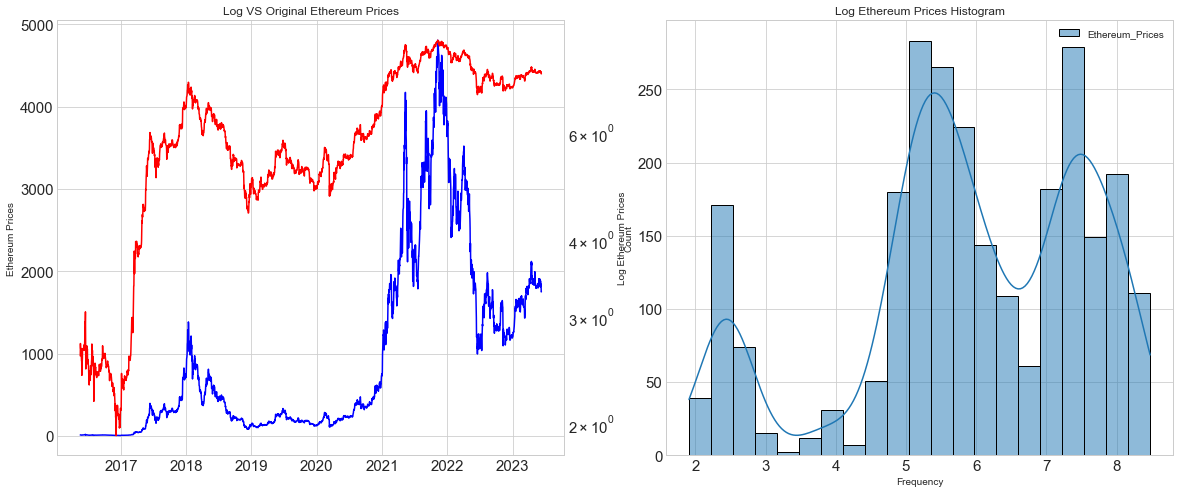

In [13]:
# Aplicação da função logarítmica à série eth
log_eth = np.log(eth)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the non-log time series on the left y-axis (primary y-axis)
axes[0].plot(eth, color="blue")
axes[0].set_ylabel('Ethereum Prices')
axes[0].set_title('Log VS Original Ethereum Prices')

# Create a twin Axes object for the right y-axis
axes_right = axes[0].twinx()

# Plot the log time series on the right y-axis (secondary y-axis)
axes_right.plot(log_eth, color="red")
axes_right.set_ylabel('Log Ethereum Prices')

# Set the y-axis scale on the right to log scale
axes_right.set_yscale('log')

# Plot the histogram of the log time series on the right graph
sns.histplot(log_eth, kde=True, color="red", ax=axes[1])
axes[1].set_xlabel('Frequency')
axes[1].set_title('Log Ethereum Prices Histogram')

plt.show()

In [27]:
log_eth.describe().T

,count,mean,std,min,25%,50%,75%,max
Ethereum_Prices,2581.0,5.904664,1.672976,1.909543,5.136739,5.89029,7.373958,8.47761


In [28]:
# Calculate Kurtosis and Skewness
kurtosis = stats.kurtosis(log_eth['Ethereum_Prices'])
skewness = stats.skew(log_eth['Ethereum_Prices'])

print(f'Kurtosis: {kurtosis}')
print(f'Skewness: {skewness}')

Kurtosis: -0.22461875188195357
Skewness: -0.6506400919674413


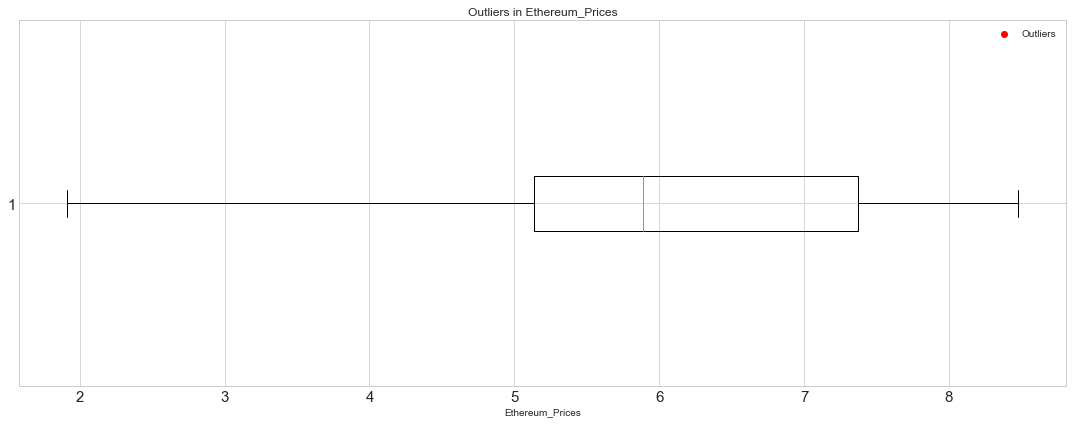

In [29]:
# Define the number of rows and columns for the subplots
nrows = 1
ncols = 1

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))

# Calculate the IQR and Tukey's fences for the column
q1 = np.percentile(log_eth['Ethereum_Prices'], 25)
q3 = np.percentile(log_eth['Ethereum_Prices'], 75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# Detect the outliers in the column
outliers = log_eth[(log_eth['Ethereum_Prices'] < lower_fence) | (log_eth['Ethereum_Prices'] > upper_fence)]

# Set the current subplot
ax = axes

# Create the boxplot
ax.boxplot(log_eth['Ethereum_Prices'], vert=False)
ax.scatter(outliers['Ethereum_Prices'], [1] * len(outliers), color='red', label='Outliers')
ax.set_xlabel('Ethereum_Prices')
ax.set_title('Outliers in Ethereum_Prices')
ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

#### Conclusões/Key take-aways da EDA:

- From the EDA performed we can clearly see that the distribution is right-skewed, with a high concentration of values on the lower end and a collection of ninety two (92) outliers on the higher end (when the prices where at their peek). This is validated by the positive Skewness value of 1.3816951807224065 that was obtained. We can also see that the distribution is sligtly leptokurtic - This is validated by Kurtosis value of 1.0320626755560944 that was obtained.

- In terms of time series in itself we can see that there is no evident linear trend, nor obvious sazonality, neither negative values, although there are lots of ups and downs over the years. It is important to note te big jump in prices that happened in 2021 and that the variance does not seem to be constant as was verified later by splitting the series in two halfs and calcultating the mean and variance to end up obtaining vastly different results. Therefore the time series doesn´t appear to be stationary increasing the odds of it having a unit root. However, unit root and other stationarity tests will still be performed in order to be sure.
- The logarithmic function allowed for the distribution of the time series to be closer to the normal distribution and also resulted in the desconsideration of the ninety two outliers that were previously identified, being now zero outliers found.

## Splitting the dataset into train and test subsets

In [14]:
#train and test split given that the test set needs to have only 100 observations

data_train = eth[:2481] 
data_test = eth[2481:]

log_eth_train = log_eth[:2481]

In [15]:
print("Tamanho da amostra de treino:", len(data_train), "\nTamanho da amostra de teste:", len(data_test))

Tamanho da amostra de treino: 2481 
Tamanho da amostra de teste: 100


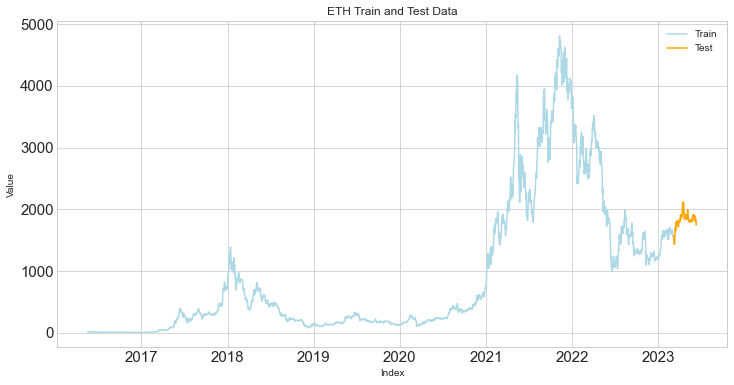

In [32]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot data_train with blue color
plt.plot(data_train.index, data_train['Ethereum_Prices'], color='#ADD8E6', label='Train')

# Plot data_test with red color
plt.plot(data_test.index, data_test['Ethereum_Prices'], color='#FFA500', label='Test')

plt.xlabel('Index')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.title('ETH Train and Test Data')  # Set the title
plt.legend()  # Show the legend

plt.show()  # Display the plot


## Analysing stationarity

### Unit root test - (ADF, PP & KPSS tests)

In [33]:
print('Ethereum Prices')
teste_estacionaridade(data_train)

Ethereum Prices
Resultados da aplicação do teste Augmented Dickey-Fuller
Não rejeito H0, tem raiz unitária -> Não estacionária

Resultados da aplicação do teste Phillips-Perron
Não rejeito H0, tem raiz unitária -> Não estacionária

Resultados da aplicação do teste Kwiatkowski–Phillips–Schmidt–Shin
Não rejeito H0, tem raiz unitária -> Não estacionária


C:\Users\joaob\AppData\Local\Temp\ipykernel_9888\106393145.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss2 = kpss(serie)


In [34]:
print('Log Ethereum Prices')
teste_estacionaridade(log_eth_train)

Log Ethereum Prices
Resultados da aplicação do teste Augmented Dickey-Fuller
Não rejeito H0, tem raiz unitária -> Não estacionária

Resultados da aplicação do teste Phillips-Perron
Não rejeito H0, tem raiz unitária -> Não estacionária

Resultados da aplicação do teste Kwiatkowski–Phillips–Schmidt–Shin
Não rejeito H0, tem raiz unitária -> Não estacionária


C:\Users\joaob\AppData\Local\Temp\ipykernel_9888\106393145.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss2 = kpss(serie)


#### Conclusões/Key take-aways dos testes ADF, PP e KPSS:
- Both the original and the log time series are non-stationary since all three tests performed (ADF, PP e KPSS) offered the same result, being unanimous in saying so.
- The logarithmic transformation alone was not enough to stationarize the time series.

#### Estacionarização da série - utilização do operador diferença

In [35]:
diff_log_eth_train= log_eth_train.diff() #calculo log returns e aplicamos a diferença.
diff_log_eth_train = diff_log_eth_train.dropna()

diff_eth_train= data_train.diff() #calculo log returns e aplicamos a diferença.
diff_eth_train = diff_eth_train.dropna()

In [36]:
teste_estacionaridade(diff_log_eth_train)

Resultados da aplicação do teste Augmented Dickey-Fuller
Rejeito H0, não tem raiz unitária -> Estacionária

Resultados da aplicação do teste Phillips-Perron
Rejeito H0, não tem raiz unitária -> Estacionária

Resultados da aplicação do teste Kwiatkowski–Phillips–Schmidt–Shin
Rejeito H0, não tem raiz unitária -> Estacionária


C:\Users\joaob\AppData\Local\Temp\ipykernel_9888\106393145.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss2 = kpss(serie)


In [37]:
teste_estacionaridade(diff_eth_train)

Resultados da aplicação do teste Augmented Dickey-Fuller
Rejeito H0, não tem raiz unitária -> Estacionária

Resultados da aplicação do teste Phillips-Perron
Rejeito H0, não tem raiz unitária -> Estacionária

Resultados da aplicação do teste Kwiatkowski–Phillips–Schmidt–Shin
Rejeito H0, não tem raiz unitária -> Estacionária


C:\Users\joaob\AppData\Local\Temp\ipykernel_9888\106393145.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss2 = kpss(serie)


#### Conclusões/Key take-aways da tentativa de estacionarização com o operador diferença:
- After applying the differencing the time series are now stationary given that all three tests performed (ADF, PP e KPSS) reached the same result. As such, first differencing proved to be enough to achieve stationarity in both cases.

### ACF and PACF

##### For Ethereum Close Prices

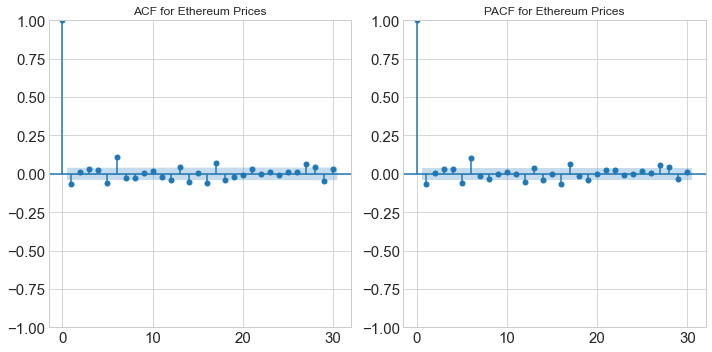

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot ACF
ax = axs[0]
plot_acf(diff_eth_train['Ethereum_Prices'], lags=30, alpha=0.05, ax=ax)
ax.set_title('ACF for Ethereum Prices')

# Plot PACF
ax = axs[1]
plot_pacf(diff_eth_train['Ethereum_Prices'], lags=30, alpha=0.05, ax=ax)
ax.set_title('PACF for Ethereum Prices')

plt.tight_layout()
plt.show()

##### For Log Ethereum Close Prices

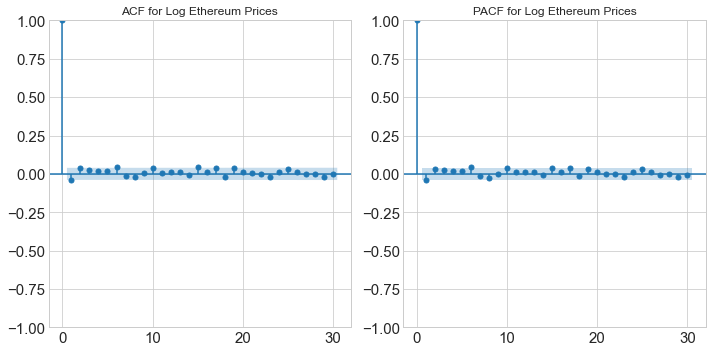

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot ACF
ax = axs[0]
plot_acf(diff_log_eth_train['Ethereum_Prices'], lags=30, alpha=0.05, ax=ax)
ax.set_title('ACF for Log Ethereum Prices')

# Plot PACF
ax = axs[1]
plot_pacf(diff_log_eth_train['Ethereum_Prices'], lags=30, alpha=0.05, ax=ax)
ax.set_title('PACF for Log Ethereum Prices')

plt.tight_layout()
plt.show()

#### Conclusões/Key take-aways dos gráficos ACF e PACF:
- The ACF and PACF plots for Ethereum Close Prices seem to exhibit some seasonality (since there are some lags higher than the confidence interval) after the last significant lag) and the significant lags for both the autoregressive and moving average parameters seem to be 1.
- On the other hand, the ACF and PACF plots for the Log Ethereum Close Prices seem to exhibit close to all lags within the confidence interval range.

## Modelling

### 1) Traditional Time Series methods - ARIMA / SARIMA Models

##### Mod1: Modelo para a Série temporal  - Coinbase Ethereum

In [40]:
# fit stepwise auto-ARIMA 
stepwise_fit = pm.auto_arima(data_train, start_p=1, # initial guess for AR(p)
                             start_q=1, # initial guess for MA(q)
                             max_p=3, # max guess for AR(p)
                             max_q=3, # max guess for MA(q)
                             #m=365,
                             seasonal=True,
                             d=1, # initial guess for I(d)
                             D=1, 
                             trace=True, error_action='ignore', # don't want to know if an order does not work
                             suppress_warnings=True, # don't want convergence warnings
                             stepwise=True) # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28060.229, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28066.593, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28058.279, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28058.497, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28064.796, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28060.176, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28060.292, Time=4.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=28056.512, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28058.406, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=28058.459, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=28056.729, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=28058.493, Time=1.43 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 8.865 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2481
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -14026.256
Date:                Fri, 23 Jun 2023   AIC                          28056.512
Time:                        16:26:25   BIC                          28068.144
Sample:                    05-18-2016   HQIC                         28060.737
                         - 03-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0643      0.010     -6.724      0.000      -0.083      -0.046
sigma2      4788.7314     40.601    117.946      0.000    4709.155    4868.308
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             47593.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              19.09   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
mod1 = SARIMAX(data_train,order=(1,1,0),seasonal_order=(0,0,0,0))

results1 = mod1.fit()
results1.summary()

C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Ethereum_Prices   No. Observations:                 2481
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -14026.256
Date:                Fri, 23 Jun 2023   AIC                          28056.512
Time:                        16:26:25   BIC                          28068.144
Sample:                    05-18-2016   HQIC                         28060.737
                         - 03-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0643      0.010     -6.724      0.000      -0.083      -0.046
sigma2      4788.7314     40.601    117.946      0.000    4709.155    4868.308
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             47593.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              19.09   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### In-sample predictions (train set predictions)

In [42]:
# Make predictions on the train set
train_predictions_1 = results1.predict(start=1, end=len(data_train['Ethereum_Prices'])-1)
train_erros_mod1 = erros(mod1, data_train['Ethereum_Prices'][1:], train_predictions_1)

<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF202ECBE0> RMSE Error: 69.18672105
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF202ECBE0> MAE Error: 33.08135867
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF202ECBE0> MAPE Error: 3.711005967
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF202ECBE0> R^2 Score: 0.9962078773


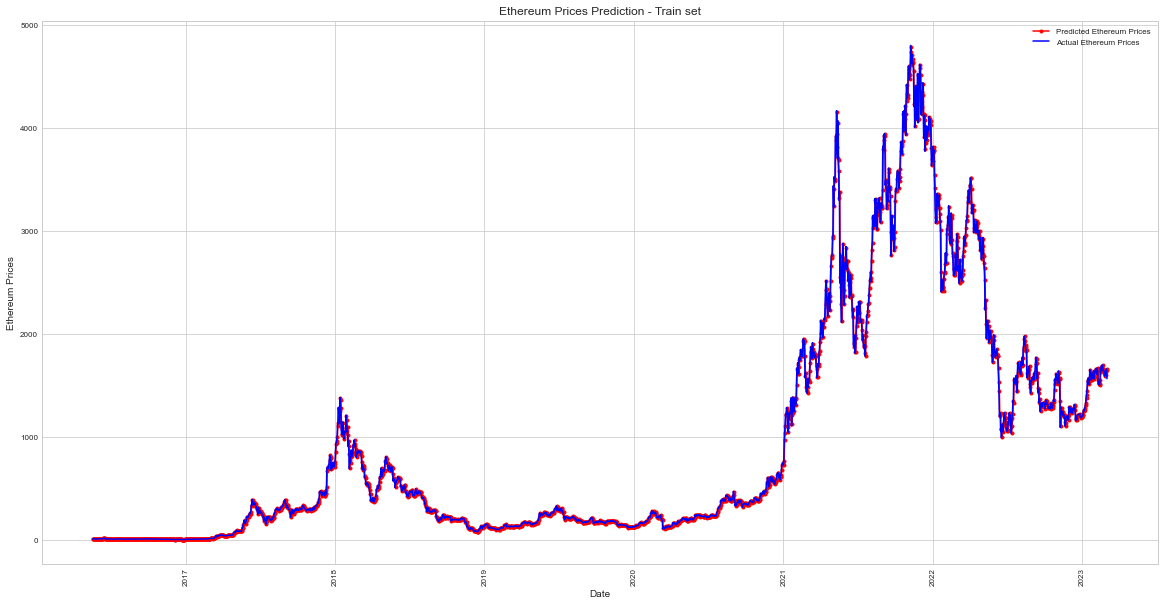

In [43]:
train_set_range = data_train['Ethereum_Prices'].index
plt.figure(figsize=(20, 10))
plt.plot(data_train['Ethereum_Prices'][1:].index, train_predictions_1, color='red', marker='.', linestyle='-',label='Predicted Ethereum Prices')
plt.plot(train_set_range, data_train['Ethereum_Prices'], color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction - Train set')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.legend()
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ethereum Prices', fontsize=10)
plt.xticks(fontsize=8,rotation='vertical')
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.show()

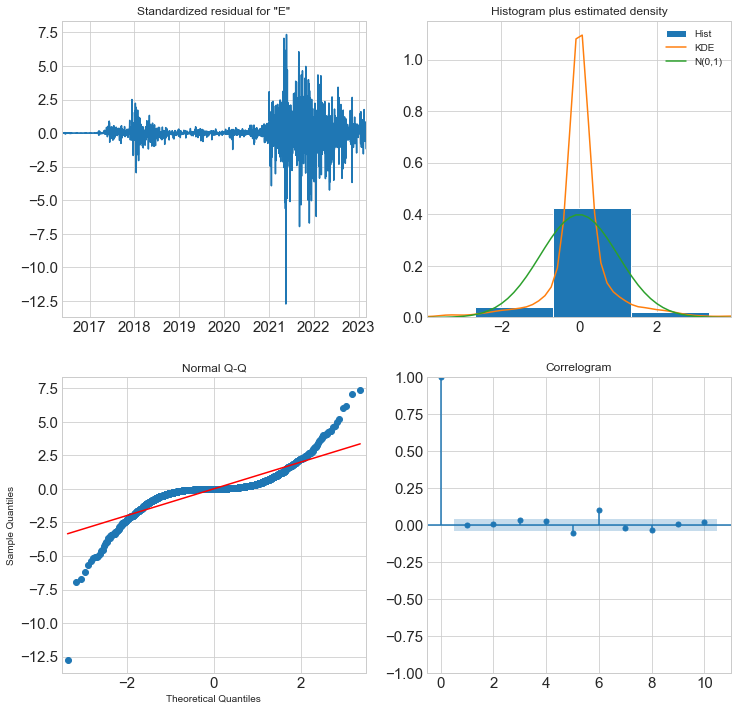

In [44]:
results1.plot_diagnostics(figsize=(12, 12))
plt.show()

###### Test set predictions

In [45]:
# Obtain predicted values
training_data = pd.DataFrame(data_train).values
test_data = pd.DataFrame(data_test).values
history = [x for x in training_data]
model1_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = SARIMAX(history, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model1_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

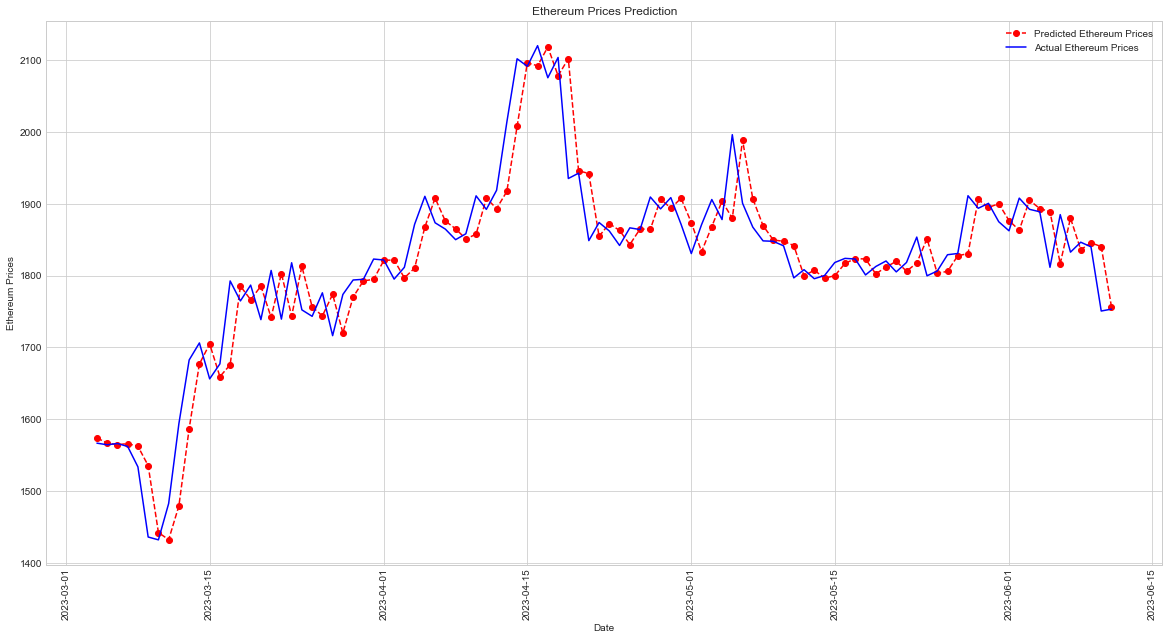

In [46]:
test_set_range = data_test.index
fig = plt.figure(figsize = (20,10))
plt.plot(test_set_range, model1_predictions, color='red', marker='o', linestyle='dashed',label='Predicted Ethereum Prices')
plt.plot(test_set_range, test_data, color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ethereum Prices', fontsize=10)
plt.xticks(fontsize=10,rotation='vertical')
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.legend()
plt.show()

In [47]:
# calcula dos erros para o modelo sem sazonalidade
erros_mod1 = erros('Modelo SARIMA(1,1,0)(0,0,0)[0] (sem componente sazonal) -', data_test['Ethereum_Prices'], model1_predictions)

Modelo SARIMA(1,1,0)(0,0,0)[0] (sem componente sazonal) - RMSE Error: 47.43169905
Modelo SARIMA(1,1,0)(0,0,0)[0] (sem componente sazonal) - MAE Error: 34.36012875
Modelo SARIMA(1,1,0)(0,0,0)[0] (sem componente sazonal) - MAPE Error: 1.893963403
Modelo SARIMA(1,1,0)(0,0,0)[0] (sem componente sazonal) - R^2 Score: 0.8573974881


##### Mod2: Inclusão de uma componente/período sazonal de seis dias ao Mod1

In [48]:
# Fit model with seasonality
mod2 = SARIMAX(data_train,order=(1,1,0),seasonal_order=(1,0,0,6))
results2 = mod2.fit()
results2.summary()

C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                   Ethereum_Prices   No. Observations:                 2481
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 6)   Log Likelihood              -14012.699
Date:                           Fri, 23 Jun 2023   AIC                          28031.397
Time:                                   16:26:46   BIC                          28048.845
Sample:                               05-18-2016   HQIC                         28037.734
                                    - 03-03-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0565      0.010     -5.592      0.000      -0.076      -0.037
ar.S.L6        0.1045      0.009     11.246      0.000       0.086       0.123
sigma2      4734.6292     40.258    117.607      0.000    4655.725    4813.533
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             47770.65
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              19.36   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### In-sample predictions (train set predictions)

In [49]:
# Make predictions on the train set
train_predictions_2 = results2.predict(start=1, end=len(data_train['Ethereum_Prices'])-1)
train_erros_mod2 = erros(mod2, data_train['Ethereum_Prices'][1:], train_predictions_2)

<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF24D84DF0> RMSE Error: 68.80863779
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF24D84DF0> MAE Error: 32.94430085
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF24D84DF0> MAPE Error: 3.726490618
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF24D84DF0> R^2 Score: 0.9962492095


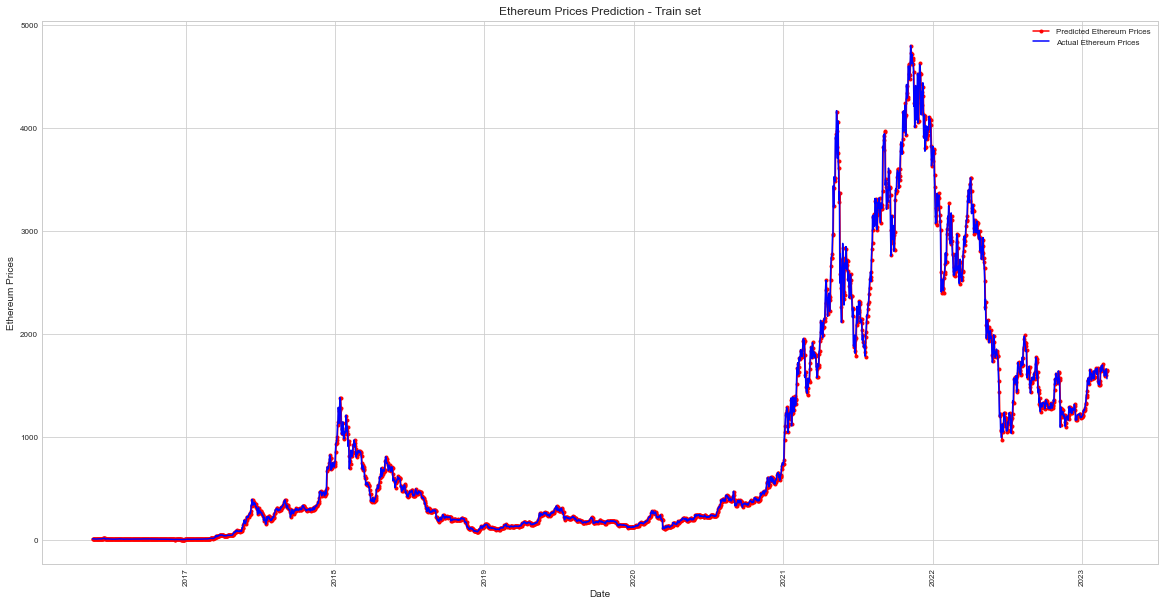

In [50]:
train_set_range = data_train['Ethereum_Prices'].index
plt.figure(figsize=(20, 10))
plt.plot(data_train['Ethereum_Prices'][1:].index, train_predictions_2, color='red', marker='.', linestyle='-',label='Predicted Ethereum Prices')
plt.plot(train_set_range, data_train['Ethereum_Prices'], color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction - Train set')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.legend()
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ethereum Prices', fontsize=10)
plt.xticks(fontsize=8,rotation='vertical')
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.show()

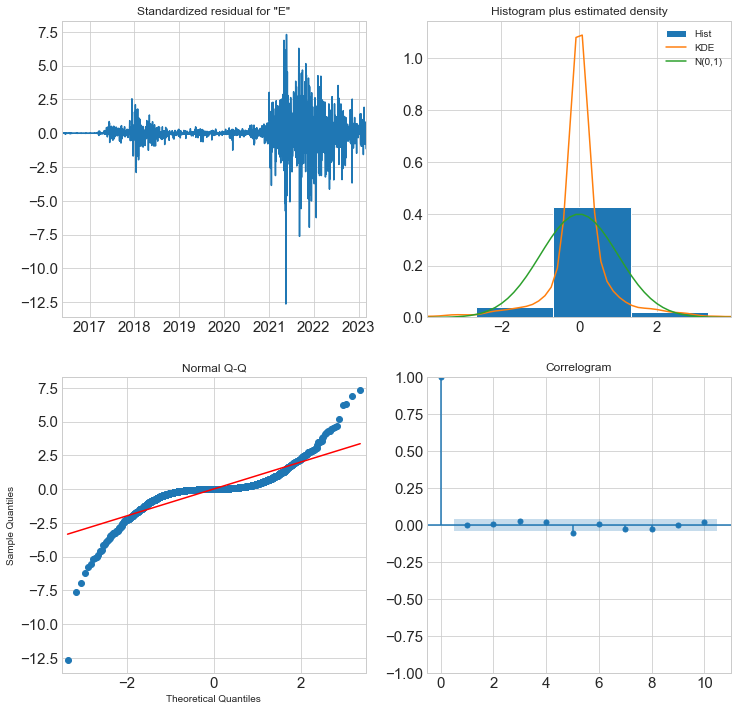

In [51]:
results2.plot_diagnostics(figsize=(12, 12))
plt.show()

###### Test set predictions

In [52]:
# Obtain predicted values
training_data = pd.DataFrame(data_train).values
test_data = pd.DataFrame(data_test).values
history = [x for x in training_data]
model2_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = SARIMAX(history, order=(1, 1, 0), seasonal_order=(1, 0, 0, 6))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model2_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

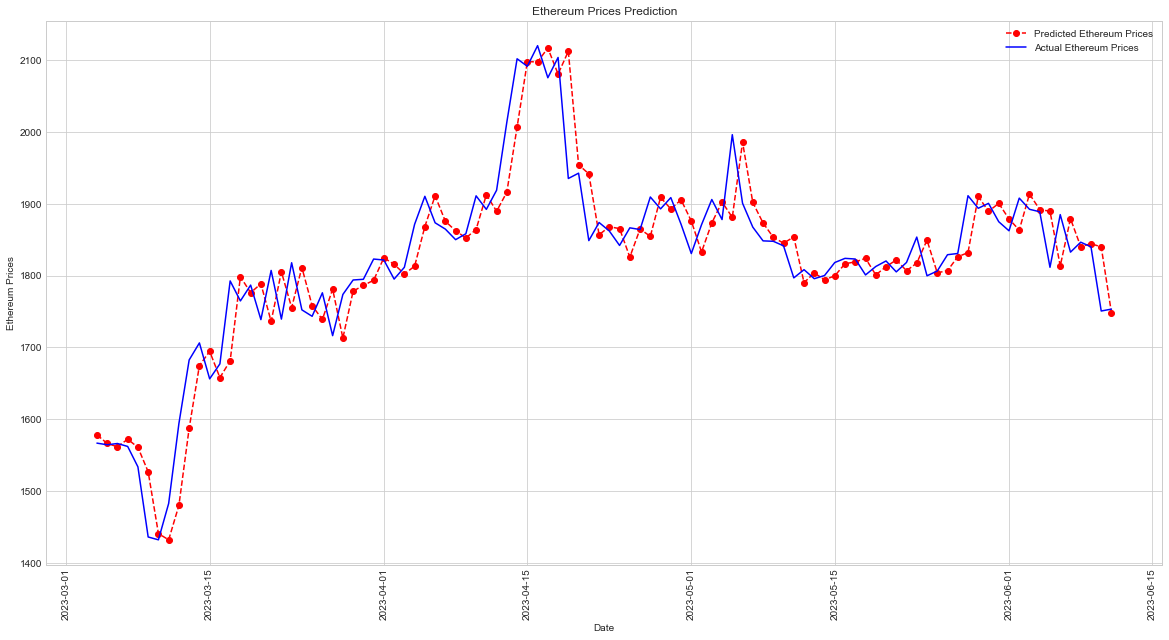

In [53]:
test_set_range = data_test.index
fig = plt.figure(figsize = (20,10))
plt.plot(test_set_range, model2_predictions, color='red', marker='o', linestyle='dashed',label='Predicted Ethereum Prices')
plt.plot(test_set_range, test_data, color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.legend()
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ethereum Prices', fontsize=10)
plt.xticks(fontsize=10,rotation='vertical')
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [54]:
# calcula os erros para o modelo com período de sazonalidade de seis dias
erros_mod2 = erros('SARIMA(1,1,0)(1,0,0)[6] (com componente sazonal) -', data_test['Ethereum_Prices'], model2_predictions)

SARIMA(1,1,0)(1,0,0)[6] (com componente sazonal) - RMSE Error: 47.80253943
SARIMA(1,1,0)(1,0,0)[6] (com componente sazonal) - MAE Error: 35.05269862
SARIMA(1,1,0)(1,0,0)[6] (com componente sazonal) - MAPE Error: 1.931090305
SARIMA(1,1,0)(1,0,0)[6] (com componente sazonal) - R^2 Score: 0.8551589219


##### Mod3: Inclusão de uma componente/período sazonal de cinco dias ao Mod1

In [55]:
# Fit model with seasonality
mod3 = SARIMAX(data_train,order=(1,1,0),seasonal_order=(1,0,0,5))
results3 = mod3.fit()
results3.summary()

C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                   Ethereum_Prices   No. Observations:                 2481
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 5)   Log Likelihood              -14022.761
Date:                           Fri, 23 Jun 2023   AIC                          28051.522
Time:                                   16:28:30   BIC                          28068.970
Sample:                               05-18-2016   HQIC                         28057.859
                                    - 03-03-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0575      0.010     -5.843      0.000      -0.077      -0.038
ar.S.L5       -0.0535      0.007     -7.499      0.000      -0.067      -0.039
sigma2      4788.6918     42.351    113.073      0.000    4705.686    4871.697
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             44501.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              18.81   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### In-sample predictions (train set predictions)

In [56]:
# Make predictions on the train set
train_predictions_3 = results3.predict(start=1, end=len(data_train['Ethereum_Prices'])-1)
train_erros_mod3 = erros(mod3, data_train['Ethereum_Prices'][1:], train_predictions_3)

<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF274058E0> RMSE Error: 69.08892441
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF274058E0> MAE Error: 33.06966039
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF274058E0> MAPE Error: 3.724855649
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF274058E0> R^2 Score: 0.9962185902


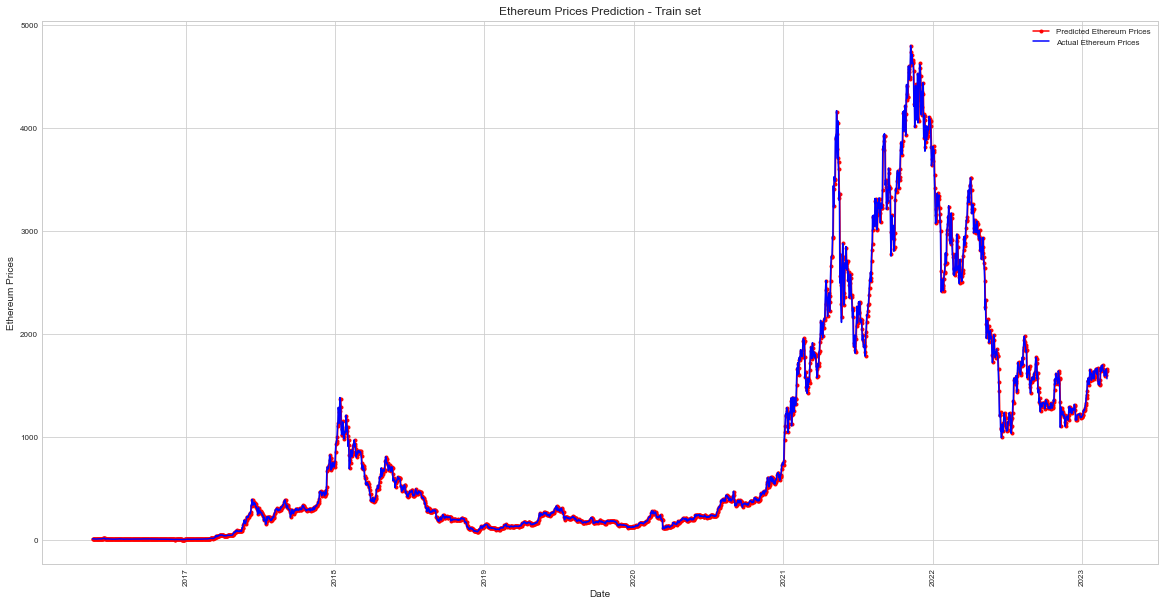

In [57]:
train_set_range = data_train['Ethereum_Prices'].index
plt.figure(figsize=(20, 10))
plt.plot(data_train['Ethereum_Prices'][1:].index, train_predictions_3, color='red', marker='.', linestyle='-',label='Predicted Ethereum Prices')
plt.plot(train_set_range, data_train['Ethereum_Prices'], color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction - Train set')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.legend()
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ethereum Prices', fontsize=10)
plt.xticks(fontsize=8,rotation='vertical')
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.show()

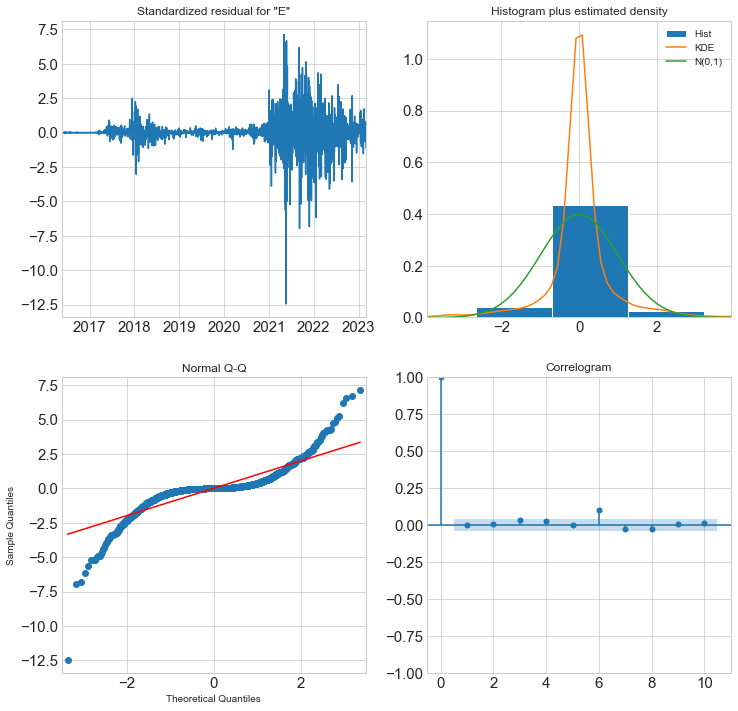

In [58]:
results3.plot_diagnostics(figsize=(12, 12))
plt.show()

###### Test set predictions

In [59]:
# Obtain predicted values
training_data = pd.DataFrame(data_train).values
test_data = pd.DataFrame(data_test).values
history = [x for x in training_data]
model3_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = SARIMAX(history, order=(1, 1, 0), seasonal_order=(1, 0, 0, 5))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model3_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

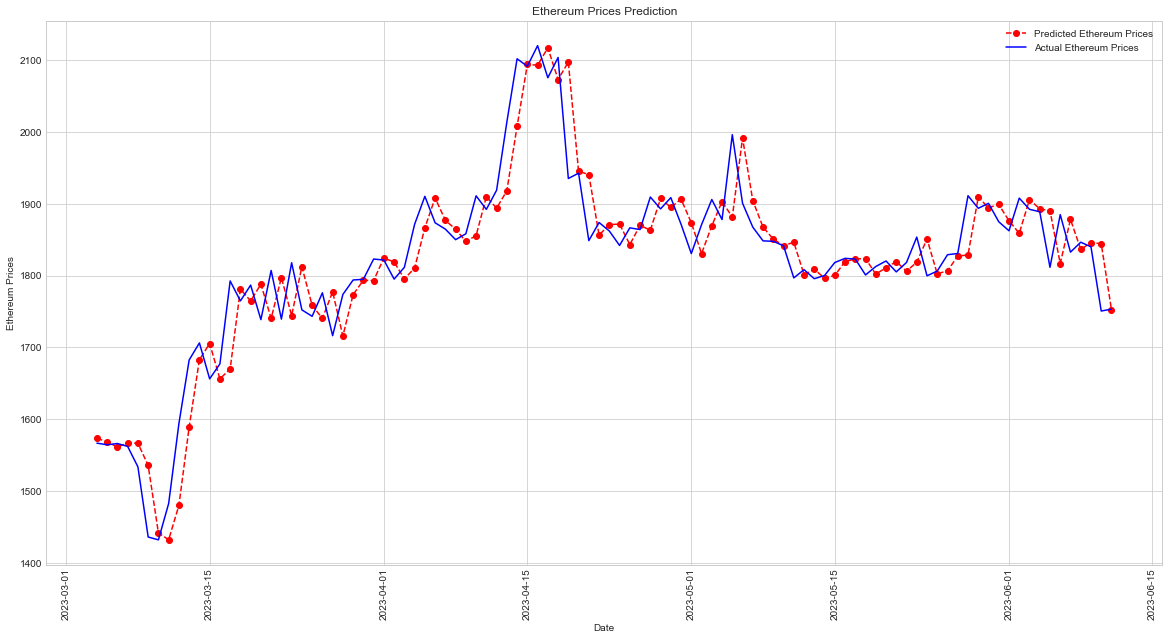

In [60]:
test_set_range = data_test.index
fig = plt.figure(figsize = (20,10))
plt.plot(test_set_range, model3_predictions, color='red', marker='o', linestyle='dashed',label='Predicted Ethereum Prices')
plt.plot(test_set_range, test_data, color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.legend()
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ethereum Prices', fontsize=10)
plt.xticks(fontsize=10,rotation='vertical')
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [61]:
# calcula os erros para o modelo com período de sazonalidade de cinco dias
erros_mod3 = erros('SARIMA(1,1,0)(1,0,0)[5] (com componente sazonal) -', data_test['Ethereum_Prices'], model3_predictions)

SARIMA(1,1,0)(1,0,0)[5] (com componente sazonal) - RMSE Error: 47.67081392
SARIMA(1,1,0)(1,0,0)[5] (com componente sazonal) - MAE Error:  34.6828116
SARIMA(1,1,0)(1,0,0)[5] (com componente sazonal) - MAPE Error: 1.912379968
SARIMA(1,1,0)(1,0,0)[5] (com componente sazonal) - R^2 Score: 0.8559560752


##### Mod4: Utiliação da série Coinbase Ethereum logaritmizada 

In [62]:
# fit stepwise auto-ARIMA 
stepwise_fit = pm.auto_arima(log_eth_train, start_p=0, # initial guess for AR(p)
                             start_q=0, # initial guess for MA(q)
                             max_p=3, # max guess for AR(p)
                             max_q=3, # max guess for MA(q) 
                             seasonal=True,
                             d=1, # initial guess for I(d)
                             D=1, 
                             trace=True, error_action='ignore', # don't want to know if an order does not work
                             suppress_warnings=True, # don't want convergence warnings
                             stepwise=True) # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7342.995, Time=1.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7344.683, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7344.426, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7341.953, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7345.715, Time=3.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7345.416, Time=0.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7350.637, Time=10.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7344.106, Time=4.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-7343.459, Time=1.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7337.573, Time=5.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7347.975, Time=3.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-7346.919, Time=9.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-7348.489, Time=0.86 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 41.892 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2481
Model:               SARIMAX(2, 1, 1)   Log Likelihood                3680.319
Date:                Fri, 23 Jun 2023   AIC                          -7350.637
Time:                        16:29:53   BIC                          -7321.557
Sample:                    05-18-2016   HQIC                         -7340.075
                         - 03-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.893      0.372      -0.000       0.000
ar.L1          0.8720      0.045     19.201      0.000       0.783       0.961
ar.L2          0.0614      0.013      4.782      0.000       0.036       0.087
ma.L1         -0.9138      0.044    -20.562      0.000      -1.001      -0.827
sigma2         0.0030   3.91e-05     77.003      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6831.69
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# Fit model with seasonality
mod4 = SARIMAX(log_eth_train,order=(2,1,1),seasonal_order=(0,0,0,0))
results4 = mod4.fit()
results4.summary()

C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Ethereum_Prices   No. Observations:                 2481
Model:               SARIMAX(2, 1, 1)   Log Likelihood                3678.244
Date:                Fri, 23 Jun 2023   AIC                          -7348.489
Time:                        16:29:54   BIC                          -7325.225
Sample:                    05-18-2016   HQIC                         -7340.039
                         - 03-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7172      0.121      5.919      0.000       0.480       0.955
ar.L2          0.0679      0.013      5.236      0.000       0.042       0.093
ma.L1         -0.7565      0.121     -6.257      0.000      -0.993      -0.520
sigma2         0.0030   3.88e-05     77.625      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6807.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### In-sample predictions (train set predictions)

In [64]:
# Apply inverse transformation to predicted values
train_predictions_4 = results4.predict(start=1, end=len(log_eth_train['Ethereum_Prices'])-1)
train_predictions_4_real = np.exp(train_predictions_4)

# Apply inverse transformation to actual values
log_eth_train_real = np.exp(log_eth_train['Ethereum_Prices'][1:])

# Calculate errors on the train set
train_errors_mod4 = erros(mod4, log_eth_train_real, train_predictions_4_real)

<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF1D969D90> RMSE Error: 69.19520186
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF1D969D90> MAE Error: 33.16822113
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF1D969D90> MAPE Error: 3.717650994
<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001DF1D969D90> R^2 Score: 0.9962069476


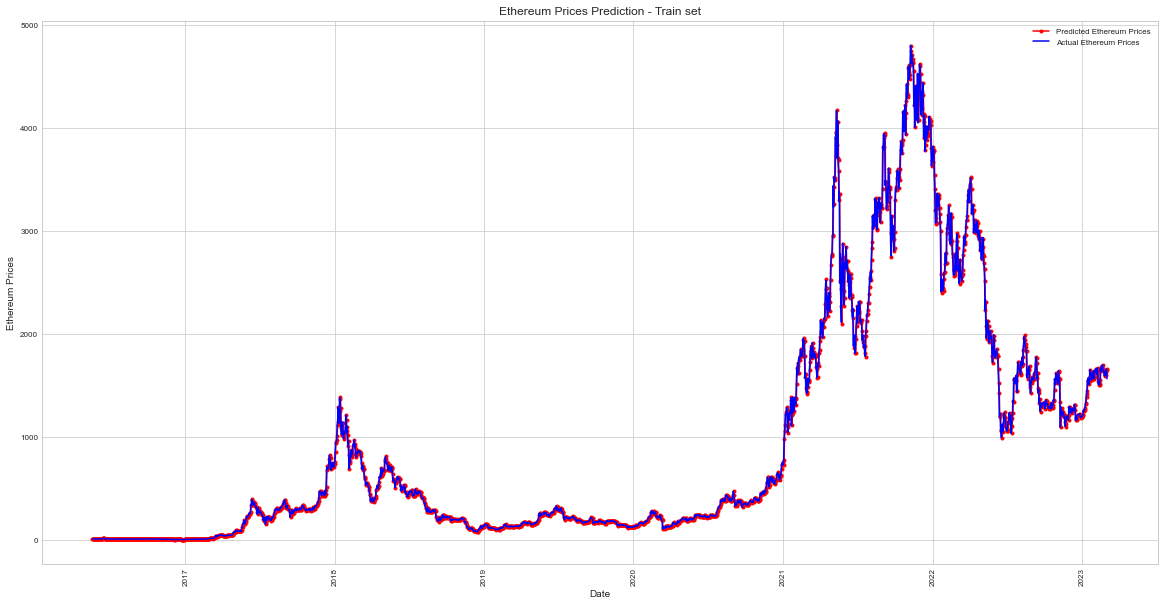

In [65]:
train_set_range = log_eth_train_real.index
plt.figure(figsize=(20, 10))
plt.plot(train_set_range, train_predictions_4_real, color='red', marker='.', linestyle='-', label='Predicted Ethereum Prices')
plt.plot(train_set_range, log_eth_train_real, color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction - Train set')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.xticks(fontsize=8, rotation='vertical')
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.show()

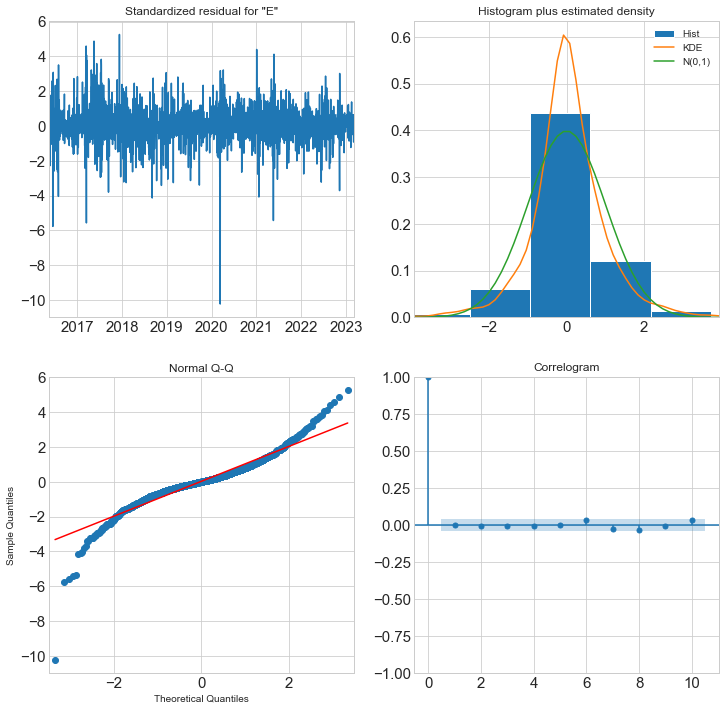

In [66]:
results4.plot_diagnostics(figsize=(12, 12))
plt.show()

###### Test set predictions

In [67]:
# Obtain predicted values
training_data = pd.DataFrame(log_eth_train).values
test_data = pd.DataFrame(data_test).values
history = [x for x in training_data]
model4_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = SARIMAX(history, order=(2, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model4_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\joaob\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


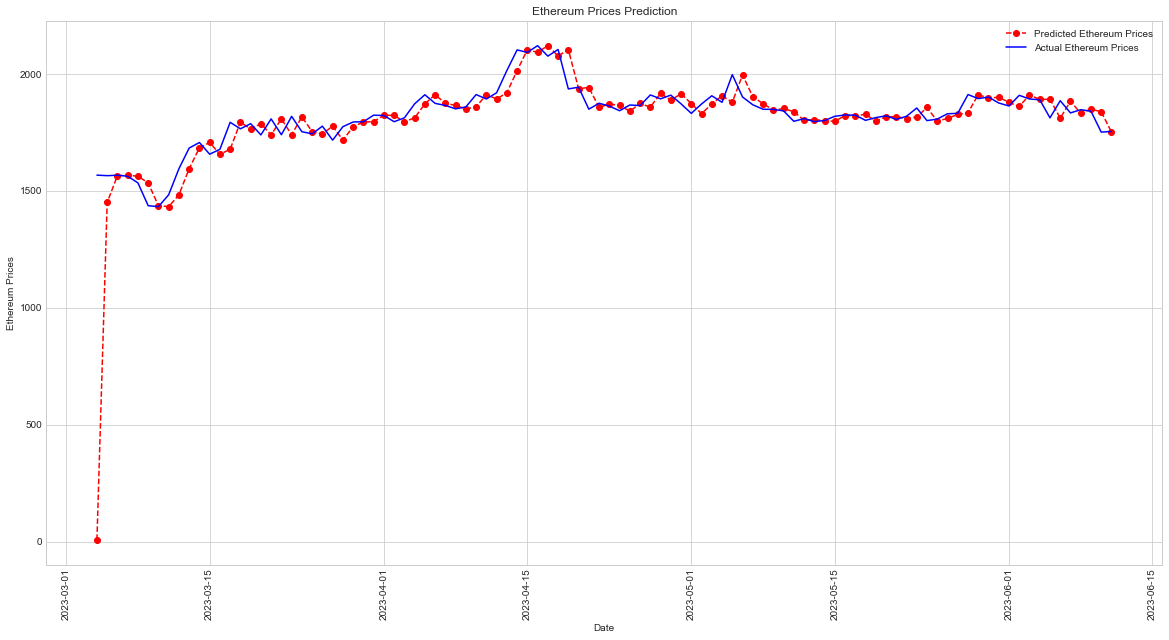

In [68]:
test_set_range = data_test.index
fig = plt.figure(figsize = (20,10))
plt.plot(test_set_range, model4_predictions, color='red', marker='o', linestyle='dashed',label='Predicted Ethereum Prices')
plt.plot(test_set_range, test_data, color='blue', label='Actual Ethereum Prices')
plt.title('Ethereum Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.legend()
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ethereum Prices', fontsize=10)
plt.xticks(fontsize=10,rotation='vertical')
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [69]:
# calcula os erros para o modelo logaritmizado
erros_mod4 = erros('SARIMA(2,1,1)(0,0,0)[0] (sem componente sazonal) -', data_test['Ethereum_Prices'], model4_predictions)

SARIMA(2,1,1)(0,0,0)[0] (sem componente sazonal) - RMSE Error:  163.525002
SARIMA(2,1,1)(0,0,0)[0] (sem componente sazonal) - MAE Error: 51.85599334
SARIMA(2,1,1)(0,0,0)[0] (sem componente sazonal) - MAPE Error: 3.000208538
SARIMA(2,1,1)(0,0,0)[0] (sem componente sazonal) - R^2 Score: -0.694954866


#### Conclusões/Key take-aways dos modelos ARIMA/SARIMA:


- **Mod1: ARIMA(1,1,0)(0,0,0)[0]**: This model performs reasonably well with relatively low RMSE and MAPE errors on both the train and test sets. However, it shows a significant fifth and sixth lag on the residuals, indicating some remaining patterns or seasonality that the model fails to capture.

- **Mod2: SARIMA(1,1,0)(1,0,0)[6]**: Introducing a seasonal component in the form of (1,0,0)[6] deteorates the predictions slightly compared to the ARIMA model. The RMSE is slightly lower while the MAPE is slightly higher. However, it still shows a significant fifth lag on the residuals.

- **Mod3: SARIMA(1,1,0)(1,0,0)[5]**: In this model, the seasonal component is modified to (1,0,0)[5]. It yields similar results to the previous model, with slightly lower errors. However, it exhibits a significant sixth lag on the residuals instead of the fifth lag seen in the previous model.

- **Mod4: SARIMA(2,1,1)(0,0,0)[0]**: This model incorporates both the autoregressive and moving average components. It also utilizes the logarithmic transformation of the data. It performs well on the train set with a relatively low RMSE and MAPE error. However, the RMSE error on the test set is significantly higher, indicating that the model may not generalize well to unseen data.

### 2) Facebook Prophet

#### Mod5: Facebook Prophet

In [16]:
eth_prophet = eth.copy()
eth_prophet.reset_index(inplace=True)

eth_prophet = pd.DataFrame({
    'ds': eth_prophet['DATE'],  # Timestamp column
    'y': eth_prophet['Ethereum_Prices'],  # Target variable
})

eth_prophet['ds'] = pd.to_datetime(eth_prophet['ds'])

In [17]:
# Split the data into training and test sets
train_set = eth_prophet[:2481]
test_set = eth_prophet[2481:]

In [18]:
model5 = Prophet()
model5.fit(train_set);

18:39:23 - cmdstanpy - INFO - Chain [1] start processing
18:39:24 - cmdstanpy - INFO - Chain [1] done processing


###### In-sample predictions (train set predictions)

In [19]:
# Make predictions on the training set
forecast = model5.predict(train_set)

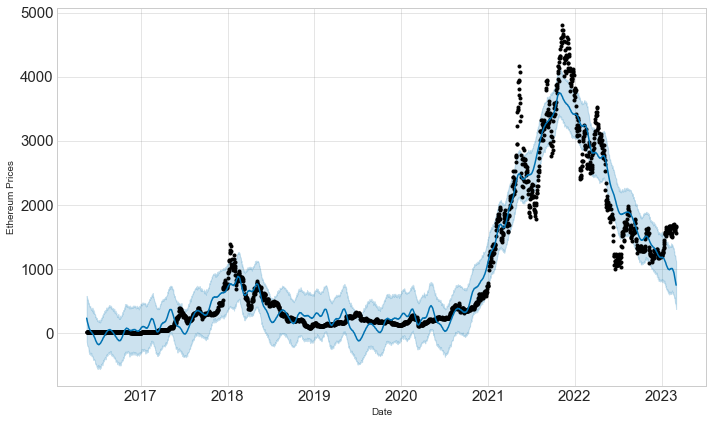

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
model5.plot(forecast, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Ethereum Prices')
plt.show()

In [21]:
# Extract the actual values from the 'train_set' DataFrame and convert to numeric values
actual_values = train_set['y'].values
# Extract the predicted values from the 'forecast' DataFrame
prophet_predictions = forecast['yhat']

# Call the 'erros' function to calculate the error metrics
error_results = erros('Facebook Prophet without hiperparameter tuning for the train set -', actual_values, prophet_predictions)

Facebook Prophet without hiperparameter tuning for the train set - RMSE Error: 283.6084434
Facebook Prophet without hiperparameter tuning for the train set - MAE Error: 192.4538395
Facebook Prophet without hiperparameter tuning for the train set - MAPE Error: 119.2603427
Facebook Prophet without hiperparameter tuning for the train set - R^2 Score: 0.9362710069


###### Test set predictions

In [22]:
# Make predictions for the future dates
forecast2 = model5.predict(test_set)

# display the most critical output columns from the forecast
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2023-06-07,2.513995,-390.219583,373.445209
96,2023-06-08,-11.208146,-376.917147,374.042963
97,2023-06-09,-24.030327,-406.792343,347.401154
98,2023-06-10,-32.492025,-413.697796,346.784699
99,2023-06-11,-41.117768,-433.458299,325.510232


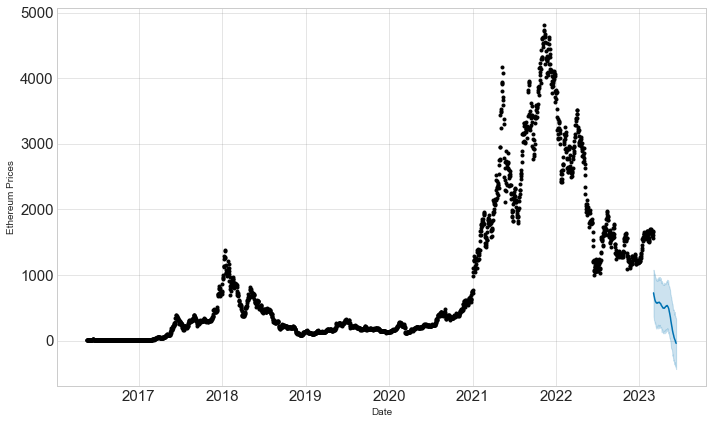

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
model5.plot(forecast2, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Ethereum Prices')
plt.show()

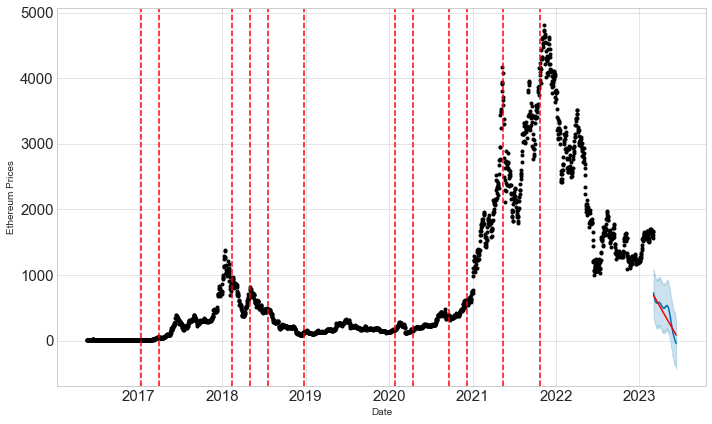

In [24]:
fig = model5.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), model5, forecast2)

# Add labels
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')

plt.show()

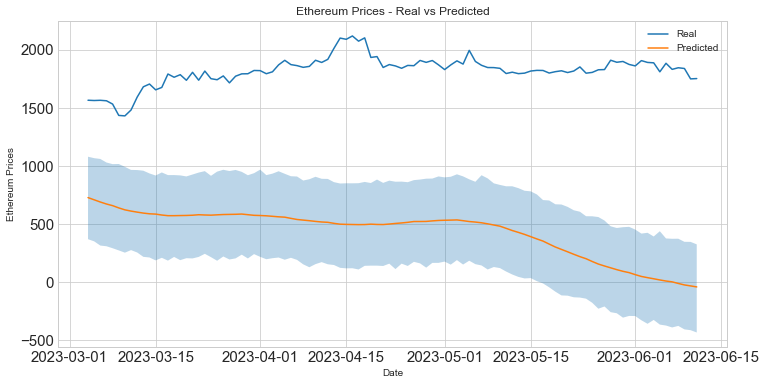

In [25]:
# Merge the forecasted values with the real values
merged_df = pd.merge(test_set, forecast2, on='ds', how='left')

# Plot the real and predicted values with confidence interval
plt.figure(figsize=(12, 6))
plt.plot(merged_df['ds'], merged_df['y'], label='Real')
plt.plot(merged_df['ds'], merged_df['yhat'], label='Predicted')
plt.fill_between(merged_df['ds'], merged_df['yhat_lower'], merged_df['yhat_upper'], alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.title('Ethereum Prices - Real vs Predicted')
plt.legend()
plt.show()

In [26]:
# Extract the actual values from the 'data_test' DataFrame and convert to numeric values
actual_values = test_set['y'].values
# Extract the predicted values from the 'forecast' DataFrame
prophet_predictions = forecast2['yhat']

# Call the 'erros' function to calculate the error metrics
error_results = erros('Facebook Prophet without hiperparameter tuning for the test set -', actual_values, prophet_predictions)

Facebook Prophet without hiperparameter tuning for the test set - RMSE Error: 1411.042626
Facebook Prophet without hiperparameter tuning for the test set - MAE Error: 1385.755104
Facebook Prophet without hiperparameter tuning for the test set - MAPE Error: 75.74157765
Facebook Prophet without hiperparameter tuning for the test set - R^2 Score: -125.2031164


#### Mod6: Facebook Prophet with hyperparameter tuning

In [27]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
hyperparameters = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_range': [0.8, 0.9, 0.95]
}

# Generate all combinations of hyperparameters
param_grid = list(ParameterGrid(hyperparameters))

# Perform grid search
best_rmse = float('inf')
best_hyperparameters = None

for params in param_grid:
    model = Prophet(**params)
    model.fit(eth_prophet)

    # Make predictions on the test set
    forecast3 = model.predict(test_set)

    # Calculate RMSE and MAPE using the erros function
    [rmse_result, mae_result, mape_result, r2_result] = erros("Prophet", test_set['y'], forecast3['yhat'])

    # Update best hyperparameters if RMSE improves
    if rmse_result < best_rmse:
        best_rmse = rmse_result
        best_hyperparameters = params

print("Best RMSE:", best_rmse)
print("Best Hyperparameters:", best_hyperparameters)

18:39:35 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 576.4830875
Prophet MAE Error: 535.6801543
Prophet MAPE Error:         nan
Prophet R^2 Score: -20.06507227


18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error:  572.620349
Prophet MAE Error: 531.4905072
Prophet MAPE Error:         nan
Prophet R^2 Score: -19.78372401


18:39:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error:   562.05812
Prophet MAE Error: 521.1751031
Prophet MAPE Error:         nan
Prophet R^2 Score: -19.02406585


18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error:  486.877101
Prophet MAE Error:  453.324138
Prophet MAPE Error:         nan
Prophet R^2 Score: -14.02548538


18:39:38 - cmdstanpy - INFO - Chain [1] done processing
18:39:38 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 508.2563221
Prophet MAE Error: 476.2988786
Prophet MAPE Error:         nan
Prophet R^2 Score: -15.37402281


18:39:38 - cmdstanpy - INFO - Chain [1] done processing
18:39:39 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 509.9757424
Prophet MAE Error: 476.7575105
Prophet MAPE Error:         nan
Prophet R^2 Score: -15.48499614


18:39:39 - cmdstanpy - INFO - Chain [1] done processing
18:39:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error:  243.180281
Prophet MAE Error: 194.1243331
Prophet MAPE Error:         nan
Prophet R^2 Score: -2.748405133


18:39:40 - cmdstanpy - INFO - Chain [1] done processing
18:39:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error:  257.896735
Prophet MAE Error: 211.1237303
Prophet MAPE Error:         nan
Prophet R^2 Score: -3.215814564


18:39:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 249.1783818
Prophet MAE Error: 201.1510294
Prophet MAPE Error:         nan
Prophet R^2 Score: -2.935596215


18:39:41 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 515.4038958
Prophet MAE Error: 483.6421545
Prophet MAPE Error:         nan
Prophet R^2 Score: -15.83779454


18:39:42 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing
18:39:42 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error:  514.615909
Prophet MAE Error: 482.7093381
Prophet MAPE Error:         nan
Prophet R^2 Score: -15.78634822


18:39:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 474.6830365
Prophet MAE Error: 441.5204813
Prophet MAPE Error:         nan
Prophet R^2 Score: -13.28226989


18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] done processing
18:39:44 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 223.9341462
Prophet MAE Error: 176.2149662
Prophet MAPE Error:         nan
Prophet R^2 Score: -2.178560298


18:39:44 - cmdstanpy - INFO - Chain [1] done processing
18:39:44 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 208.1035669
Prophet MAE Error: 162.0217603
Prophet MAPE Error:         nan
Prophet R^2 Score: -1.745041155


18:39:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 222.8093396
Prophet MAE Error: 174.9741294
Prophet MAPE Error:         nan
Prophet R^2 Score: -2.146709092


18:39:45 - cmdstanpy - INFO - Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1] done processing
18:39:46 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 503.1279373
Prophet MAE Error: 470.9500537
Prophet MAPE Error:         nan
Prophet R^2 Score: -15.04525702


18:39:47 - cmdstanpy - INFO - Chain [1] done processing
18:39:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 529.3659396
Prophet MAE Error: 498.2383931
Prophet MAPE Error:         nan
Prophet R^2 Score: -16.76240635


18:39:47 - cmdstanpy - INFO - Chain [1] done processing
18:39:48 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error:  498.462785
Prophet MAE Error: 466.5893823
Prophet MAPE Error:         nan
Prophet R^2 Score: -14.74908371


18:39:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 433.4459392
Prophet MAE Error: 363.4727358
Prophet MAPE Error:         nan
Prophet R^2 Score: -10.90857207


18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 435.0499663
Prophet MAE Error: 364.8360477
Prophet MAPE Error:         nan
Prophet R^2 Score: -10.99687381


18:39:51 - cmdstanpy - INFO - Chain [1] start processing
18:39:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error:  431.869306
Prophet MAE Error: 360.8186206
Prophet MAPE Error:         nan
Prophet R^2 Score: -10.82209622


18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error:  537.225831
Prophet MAE Error: 497.3082988
Prophet MAPE Error:         nan
Prophet R^2 Score: -17.29378559


18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 536.9387539
Prophet MAE Error: 497.4478617
Prophet MAPE Error:         nan
Prophet R^2 Score: -17.27423953


18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 537.4444292
Prophet MAE Error: 497.9750119
Prophet MAPE Error:         nan
Prophet R^2 Score: -17.30867617


18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:57 - cmdstanpy - INFO - Chain [1] done processing
18:39:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 158.5098265
Prophet MAE Error: 129.0588504
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.5925834313


18:39:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error:  159.249496
Prophet MAE Error: 128.9428956
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.6074813579


18:39:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 159.8321099
Prophet MAE Error: 129.2260639
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.6192648061


18:40:00 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 118.3679121
Prophet MAE Error: 95.25630584
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.1119083503


18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 118.7823745
Prophet MAE Error: 95.67756424
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.1056782002


18:40:03 - cmdstanpy - INFO - Chain [1] done processing
18:40:03 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 120.2863319
Prophet MAE Error:  97.0307184
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.08288800308


18:40:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 154.0042853
Prophet MAE Error: 126.2577904
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.5033338035


18:40:04 - cmdstanpy - INFO - Chain [1] start processing
18:40:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 154.1012345
Prophet MAE Error: 126.5019186
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.5052271662


18:40:05 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 154.0006662
Prophet MAE Error: 126.4670488
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.5032631478


18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing
18:40:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 111.9204451
Prophet MAE Error: 90.10677727
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.2060216337


18:40:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error:  111.770228
Prophet MAE Error: 90.04764603
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.2081515227


18:40:08 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
18:40:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 111.8756942
Prophet MAE Error: 90.07966042
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.2066564439


18:40:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 346.8418151
Prophet MAE Error: 260.0569652
Prophet MAPE Error:         nan
Prophet R^2 Score: -6.625225871


18:40:12 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 340.1892722
Prophet MAE Error: 254.9632174
Prophet MAPE Error:         nan
Prophet R^2 Score: -6.335522275


18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 346.8952897
Prophet MAE Error: 261.9883207
Prophet MAPE Error:         nan
Prophet R^2 Score: -6.627577302


18:40:18 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] done processing
18:40:20 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 420.2542545
Prophet MAE Error:  349.083054
Prophet MAPE Error:         nan
Prophet R^2 Score: -10.19474098


18:40:21 - cmdstanpy - INFO - Chain [1] done processing
18:40:22 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 419.1784717
Prophet MAE Error: 348.0369286
Prophet MAPE Error:         nan
Prophet R^2 Score: -10.13750089


18:40:23 - cmdstanpy - INFO - Chain [1] done processing
18:40:23 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 419.0186251
Prophet MAE Error:  347.981238
Prophet MAPE Error:         nan
Prophet R^2 Score: -10.12900832


18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 156.6344096
Prophet MAE Error: 133.3242161
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.5551209107


18:40:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 157.4426344
Prophet MAE Error: 134.8871637
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.571210989


18:40:26 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 156.9011556
Prophet MAE Error: 133.6080647
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.5604221141


18:40:29 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 135.3036012
Prophet MAE Error: 112.1479358
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.1604021476


18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:32 - cmdstanpy - INFO - Chain [1] done processing
18:40:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 137.2299072
Prophet MAE Error: 114.0965542
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.1936784443


18:40:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 134.0944082
Prophet MAE Error: 111.0390228
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.1397540608


18:40:33 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] done processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 152.0274128
Prophet MAE Error: 126.1980333
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.464986497


18:40:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 152.1296426
Prophet MAE Error:  126.314093
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.4669573981


18:40:38 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 152.0068288
Prophet MAE Error: 126.5016466
Prophet MAPE Error:         nan
Prophet R^2 Score: -0.4645898147


18:40:42 - cmdstanpy - INFO - Chain [1] done processing
18:40:42 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE Error: 122.0556951
Prophet MAE Error: 101.0596092
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.05570887394


18:40:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 121.8426647
Prophet MAE Error: 100.9793407
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.05900224136


18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE Error: 122.1623315
Prophet MAE Error: 101.1703837
Prophet MAPE Error:         nan
Prophet R^2 Score: 0.05405815431
Best RMSE: 111.77022802789376
Best Hyperparameters: {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


In [28]:
# Create a Prophet model with the best hyperparameters
model6 = Prophet(changepoint_prior_scale=best_hyperparameters['changepoint_prior_scale'],
                seasonality_prior_scale=best_hyperparameters['seasonality_prior_scale'],
                seasonality_mode=best_hyperparameters['seasonality_mode'],
                changepoint_range=best_hyperparameters['changepoint_range'])

# Fit the model to the train dataset
model6.fit(train_set)

18:40:48 - cmdstanpy - INFO - Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing


###### In-sample predictions (train set predictions)

In [29]:
# Make predictions on the training set
forecast4 = model6.predict(train_set)

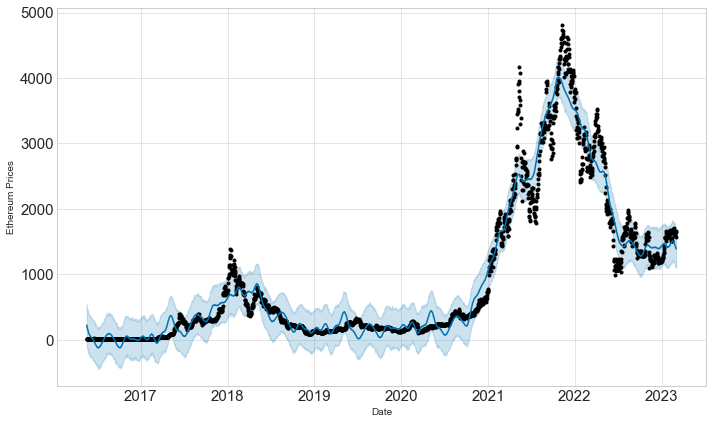

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
model6.plot(forecast4, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Ethereum Prices')
plt.show()

In [31]:
# Extract the actual values from the 'train_set' DataFrame and convert to numeric values
actual_values = train_set['y'].values
# Extract the predicted values from the 'forecast' DataFrame
prophet_predictions = forecast4['yhat']

# Call the 'erros' function to calculate the error metrics
error_results = erros('Facebook Prophet with hiperparameter tuning for the train set -', actual_values, prophet_predictions)

Facebook Prophet with hiperparameter tuning for the train set - RMSE Error: 235.7022491
Facebook Prophet with hiperparameter tuning for the train set - MAE Error: 155.3604146
Facebook Prophet with hiperparameter tuning for the train set - MAPE Error: 78.66754193
Facebook Prophet with hiperparameter tuning for the train set - R^2 Score: 0.9559824164


###### Test set predictions

In [32]:
# Make predictions for the future dates
forecast5 = model6.predict(test_set)

# display the most critical output columns from the forecast
forecast5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2023-06-07,1344.888702,964.028564,1724.578482
96,2023-06-08,1337.358420,967.538327,1712.330097
97,2023-06-09,1330.697821,972.857045,1731.949851
98,2023-06-10,1330.165156,977.570502,1702.929920
99,2023-06-11,1327.671479,969.021997,1743.106917


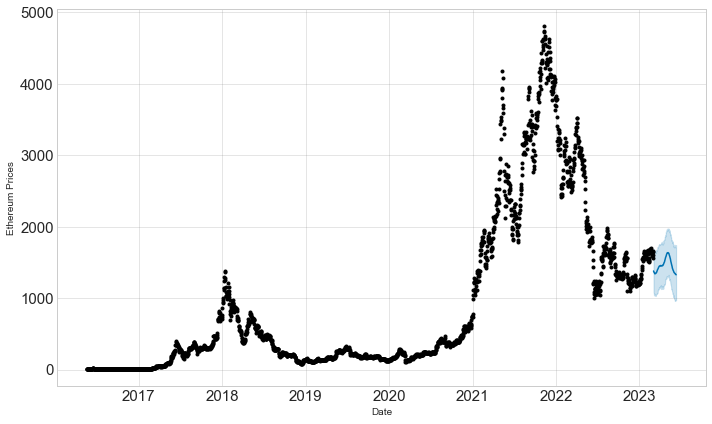

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
model6.plot(forecast5, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Ethereum Prices')
plt.show()

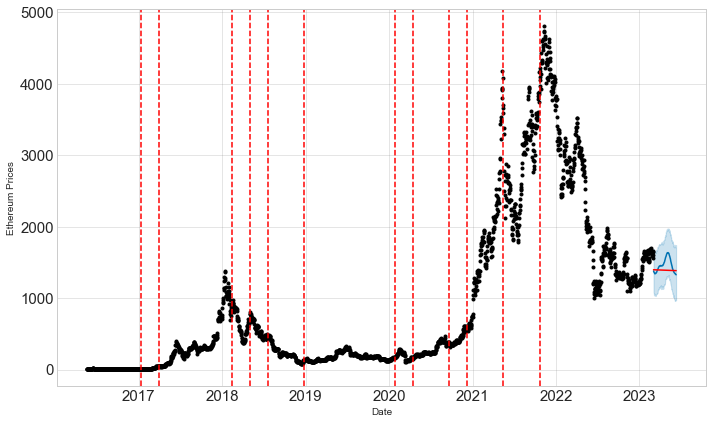

In [34]:
fig = model6.plot(forecast5)
a = add_changepoints_to_plot(fig.gca(), model5, forecast5)

# Add labels
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')

plt.show()

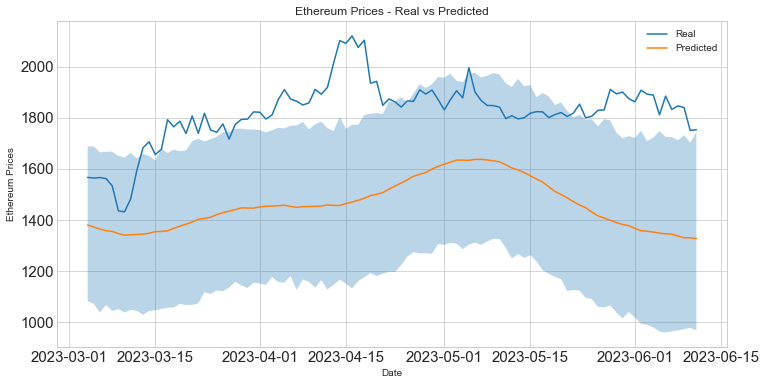

In [35]:
# Merge the forecasted values with the real values
merged_df2 = pd.merge(test_set, forecast5, on='ds', how='left')
merged_df2['predicted'] = forecast5['yhat']

# Plot the real and predicted values with confidence interval
plt.figure(figsize=(12, 6))
plt.plot(merged_df2['ds'], merged_df2['y'], label='Real')
plt.plot(merged_df2['ds'], merged_df2['predicted'], label='Predicted')
plt.fill_between(merged_df2['ds'], forecast5['yhat_lower'], forecast5['yhat_upper'], alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.title('Ethereum Prices - Real vs Predicted')
plt.legend()
plt.show()

In [36]:
# Extract the actual values from the 'data_test' DataFrame and convert to numeric values
actual_values = test_set['y'].values
# Extract the predicted values from the 'forecast' DataFrame
prophet_predictions = forecast5['yhat']

# Call the 'erros' function to calculate the error metrics
error_results = erros('Facebook Prophet with hiperparameter tuning for the test set -', actual_values, prophet_predictions)

Facebook Prophet with hiperparameter tuning for the test set - RMSE Error: 380.2679121
Facebook Prophet with hiperparameter tuning for the test set - MAE Error: 360.2272481
Facebook Prophet with hiperparameter tuning for the test set - MAPE Error: 19.54339744
Facebook Prophet with hiperparameter tuning for the test set - R^2 Score: -8.165774586


#### Mod7: Facebook Prophet with log transformation dataset

In [37]:
log_eth_prophet = log_eth.copy()
log_eth_prophet.reset_index(inplace=True)

log_eth_prophet = pd.DataFrame({
    'ds': log_eth_prophet['DATE'],  # Timestamp column
    'y': log_eth_prophet['Ethereum_Prices'],  # Target variable
})

log_eth_prophet['ds'] = pd.to_datetime(log_eth_prophet['ds'])

In [38]:
# Split the data into training and test sets
log_train_set = log_eth_prophet[:2481]
log_test_set = log_eth_prophet[2481:]

In [39]:
model7 = Prophet()
model7.fit(log_train_set);

18:42:03 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] done processing


###### In-sample predictions (train set predictions)

In [40]:
# Make predictions on the training set
forecast8 = model7.predict(log_train_set)

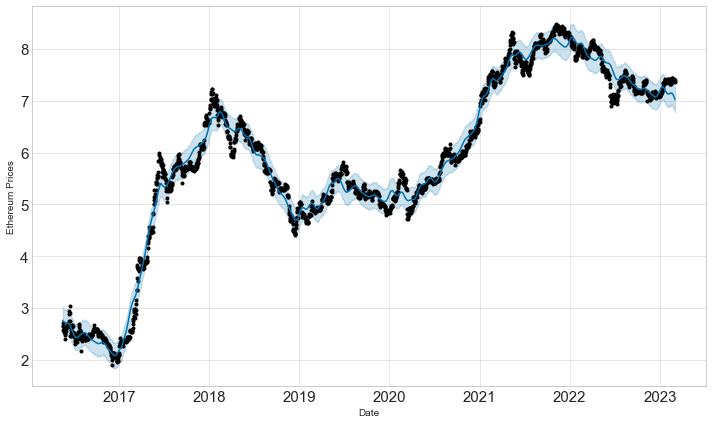

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
model7.plot(forecast8, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Ethereum Prices')
plt.show()

In [43]:
predicted_log_train_values = forecast8[['yhat', 'yhat_lower', 'yhat_upper']]

# apply exponential function to invert the log-scale predictions
predicted_train_normal_values = np.exp(predicted_log_train_values)

# update the forecast dataframe with the inverted normal-scale predictions
forecast8[['yhat', 'yhat_lower', 'yhat_upper']] = predicted_train_normal_values

# print the updated forecast values
forecast8[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2476,2023-02-27,1183.942344,922.794932,1522.969454
2477,2023-02-28,1169.871018,908.217014,1485.094621
2478,2023-03-01,1156.338727,888.525438,1464.860093
2479,2023-03-02,1136.843750,892.162213,1443.458684
2480,2023-03-03,1122.606412,872.892928,1423.572207


In [44]:
# Extract the actual values from the 'data_test' DataFrame and convert to numeric values
actual_values = train_set['y'].values
# Extract the predicted values from the 'forecast' DataFrame
prophet_predictions = forecast8['yhat']

# Call the 'erros' function to calculate the error metrics
error_results = erros('Facebook Prophet with log transformation for the train set -', actual_values, prophet_predictions)

Facebook Prophet with log transformation for the train set - RMSE Error: 275.5760715
Facebook Prophet with log transformation for the train set - MAE Error: 141.5109475
Facebook Prophet with log transformation for the train set - MAPE Error: 15.07835197
Facebook Prophet with log transformation for the train set - R^2 Score: 0.9398297587


###### Test set predictions

In [45]:
# Make predictions for the future dates
forecast9 = model7.predict(log_test_set)

predicted_log_values = forecast9[['yhat', 'yhat_lower', 'yhat_upper']]

# apply exponential function to invert the log-scale predictions
predicted_normal_values = np.exp(predicted_log_values)

# update the forecast dataframe with the inverted normal-scale predictions
forecast9[['yhat', 'yhat_lower', 'yhat_upper']] = predicted_normal_values

# print the updated forecast values
forecast9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2023-06-07,867.688548,582.423729,1300.323201
96,2023-06-08,862.791570,574.825203,1274.695026
97,2023-06-09,861.332871,566.280491,1309.864891
98,2023-06-10,858.939072,591.750716,1314.540694
99,2023-06-11,855.578408,569.006806,1298.423062


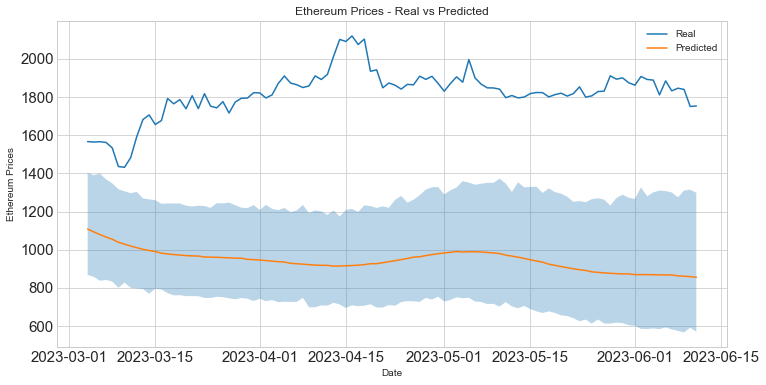

In [46]:
# merge the forecasted values with the real values
merged_df3 = pd.merge(test_set, forecast9, on='ds', how='left')
merged_df3['predicted'] = forecast9['yhat']

# plot the real and predicted values with confidence interval
plt.figure(figsize=(12, 6))
plt.plot(merged_df3['ds'], merged_df3['y'], label='Real')
plt.plot(merged_df3['ds'], merged_df3['predicted'], label='Predicted')
plt.fill_between(merged_df3['ds'], forecast9['yhat_lower'], forecast9['yhat_upper'], alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Ethereum Prices')
plt.title('Ethereum Prices - Real vs Predicted')
plt.legend()
plt.show()

In [47]:
# Extract the actual values from the 'data_test' DataFrame and convert to numeric values
actual_values = test_set['y'].values
# Extract the predicted values from the 'forecast' DataFrame
prophet_predictions = forecast9['yhat']

# Call the 'erros' function to calculate the error metrics
error_results = erros('Facebook Prophet with log transformation for the test set -', actual_values, prophet_predictions)

Facebook Prophet with log transformation for the test set - RMSE Error: 890.2508678
Facebook Prophet with log transformation for the test set - MAE Error: 875.3161605
Facebook Prophet with log transformation for the test set - MAPE Error: 47.67906781
Facebook Prophet with log transformation for the test set - R^2 Score: -49.23595045


#### Conclusões/Key take-aways dos modelos criados com o Facebook Prophet (com e sem tuning de hiperparâmetros):
- The models without hyperparameter tuning performed worse in terms of RMSE and MAPE errors compared to the models with hyperparameter tuning. This suggests that tuning the hyperparameters can significantly improve the model's performance.
- The MAPE errors for the models with hyperparameter tuning are relatively lower, indicating a better fit to the data compared to the models without tuning.
- The test set errors are generally higher than the train set errors, which is expected as the models are trained on the train set and may not generalize well to unseen data.
- The RMSE and MAPE values for both the train and test sets can be further reduced. Consider exploring additional tuning options, such as adjusting seasonality parameters, changing growth models, or applying additional data preprocessing techniques.
- It's important to note that the MAPE error for the model with hyperparameter tuning on the test set is significantly lower than the other models, suggesting it provides a better estimation of the percentage error in the predictions.

### 3) Redes Neuronais/Neural Networks & Deep Learning

In [15]:
lags = 10

# create a new DataFrame to store the lagged features
df_redes_lags = eth.copy()

# create lagged features for the 'Ethereum_Prices' column in the DataFrame
for i in range(1, lags+1):
    df_redes_lags[f'Ethereum_Prices_{i}d'] = df_redes_lags['Ethereum_Prices'].shift(i)

# drop rows with missing values
df_redes_lags.dropna(inplace=True)    
    
# print the updated DataFrame
df_redes_lags.head()

,Ethereum_Prices,Ethereum_Prices_1d,Ethereum_Prices_2d,Ethereum_Prices_3d,Ethereum_Prices_4d,Ethereum_Prices_5d,Ethereum_Prices_6d,Ethereum_Prices_7d,Ethereum_Prices_8d,Ethereum_Prices_9d,Ethereum_Prices_10d
DATE,,,,,,,,,,,
2016-05-28,12.02,10.98,12.47,12.61,12.77,13.61,14.17,14.17,14.17,14.90,13.18
2016-05-29,12.34,12.02,10.98,12.47,12.61,12.77,13.61,14.17,14.17,14.17,14.90
2016-05-30,12.88,12.34,12.02,10.98,12.47,12.61,12.77,13.61,14.17,14.17,14.17
2016-05-31,14.16,12.88,12.34,12.02,10.98,12.47,12.61,12.77,13.61,14.17,14.17
2016-06-01,13.93,14.16,12.88,12.34,12.02,10.98,12.47,12.61,12.77,13.61,14.17


In [16]:
df_redes_lags.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2571 entries, 2016-05-28 to 2023-06-11
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ethereum_Prices      2571 non-null   float64
 1   Ethereum_Prices_1d   2571 non-null   float64
 2   Ethereum_Prices_2d   2571 non-null   float64
 3   Ethereum_Prices_3d   2571 non-null   float64
 4   Ethereum_Prices_4d   2571 non-null   float64
 5   Ethereum_Prices_5d   2571 non-null   float64
 6   Ethereum_Prices_6d   2571 non-null   float64
 7   Ethereum_Prices_7d   2571 non-null   float64
 8   Ethereum_Prices_8d   2571 non-null   float64
 9   Ethereum_Prices_9d   2571 non-null   float64
 10  Ethereum_Prices_10d  2571 non-null   float64
dtypes: float64(11)
memory usage: 241.0 KB


In [17]:
cols=['Ethereum_Prices'] # vou usar apenas os preços de  ontem para alcançar os precos de hoje

y = df_redes_lags.Ethereum_Prices

X = df_redes_lags[cols]

print(X.shape, y.shape)

(2571, 1) (2571,)


In [18]:
# Specify the column name for the target variable
target_col = 'Ethereum_Prices'

# Create a list to store the lagged feature column names
x_cols = []

# Append the lagged feature column names to the list
for i in range(1, lags):
    x_cols.append(f'{target_col}_{i}d')

# Extract the lagged features (X) and target variable (y)
X = df_redes_lags[x_cols]
y = df_redes_lags[[target_col]]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2571, 9)
y shape: (2571, 1)


In [19]:
train_size = len(df_redes_lags) - 100

X_TRAIN = X[:train_size]
X_TEST = X[train_size:]
Y_TRAIN = y[:train_size]
Y_TEST = y[train_size:]

In [20]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_TRAIN = scaler.fit_transform(X_TRAIN.values)
X_TEST = scaler.transform(X_TEST.values)

Y_TRAIN_S = scaler.fit_transform(Y_TRAIN.values)
Y_TEST_S = scaler.transform(Y_TEST.values)

print(X_TRAIN.shape, X_TEST.shape)
print(Y_TRAIN_S.shape, Y_TEST_S.shape)

(2471, 9) (100, 9)
(2471, 1) (100, 1)


#### Mod8: Long-Short-Term Memory Neural Network

In [21]:
# Define the LSTM model
model8 = Sequential()
model8.add(LSTM(units=32, input_shape=(9, 1)))  # Adjust the units as needed
model8.add(Dense(units=1))  # Output layer with 1 unit for regression

# Compile the model
model8.compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss function as needed

# Print the model summary
model8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm_model = model8.fit(X_TRAIN,
                    Y_TRAIN_S,
                    batch_size=8, #will cycle through all samples
                    epochs=50, # maximum number of times the training algo= 1 # number of samples per mini-batch
                    verbose=1)

Epoch 1/50
309/309 [==============================] - 7s 11ms/step - loss: 0.0011
Epoch 2/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 3/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 4/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 5/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0010
Epoch 6/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 7/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 8/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 9/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0010
Epoch 10/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 11/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 12/50
309/309 [==============================] - 4s 12ms/step - loss: 0.0011
Epoch 13/50
3

###### In-sample predictions (train set predictions)

In [26]:
t_predictions3 = model8.predict(X_TRAIN)

78/78 [==============================] - 1s 5ms/step


In [27]:
X_PRED_T = scaler.inverse_transform(t_predictions3)

In [28]:
train_lstm_predictions = pd.DataFrame(data= X_PRED_T, index=Y_TRAIN.index, columns=Y_TRAIN.columns)

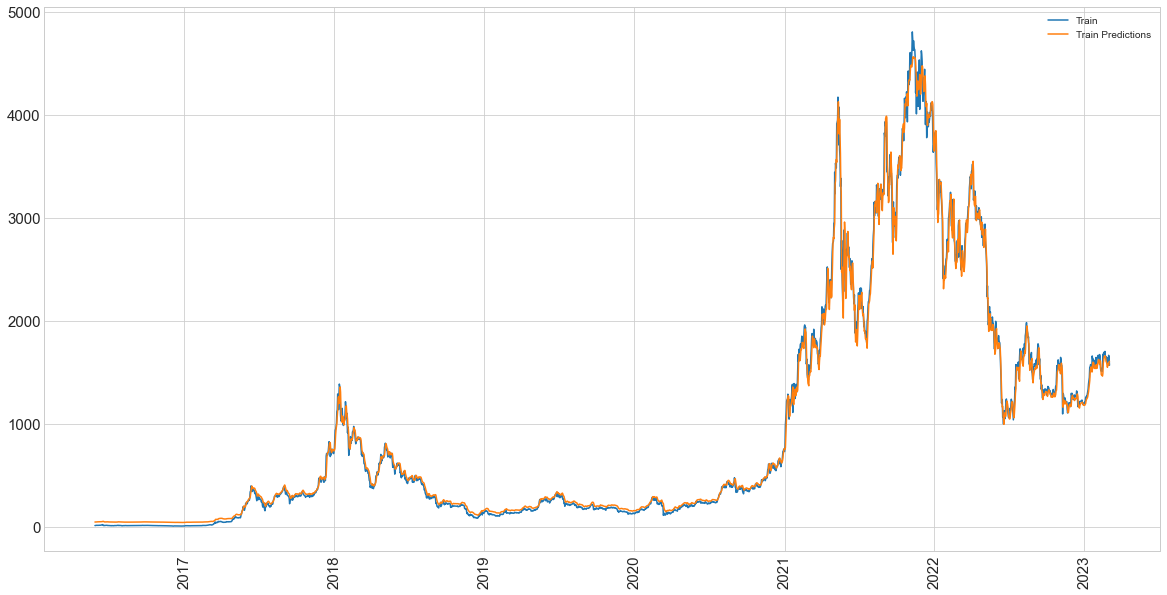

In [29]:
for column in Y_TRAIN.columns:
    # Get the train set data and corresponding predictions
    train_data = Y_TRAIN['Ethereum_Prices']
    train_predictions_data = train_lstm_predictions['Ethereum_Prices']
    
    # Visualize the data
    plt.figure(figsize=(20,10))
    plt.plot(train_data)
    plt.plot(train_predictions_data)
    plt.legend(['Train', 'Train Predictions'])
    plt.xticks(rotation=90)
    plt.show()

In [30]:
mse = mean_squared_error(Y_TRAIN, X_PRED_T)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_TRAIN, X_PRED_T)
avg_actual = np.mean(Y_TRAIN['Ethereum_Prices'])
mape = (mae / avg_actual) * 100
r2 = r2_score(Y_TRAIN, X_PRED_T)

print('Modelo LSTM para o conjunto de treino - RMSE Error:', rmse)
print('Modelo LSTM para o conjunto de treino - MAE Error:', mae)
print('Modelo LSTM para o conjunto de treino - MAPE Error:', mape)
print('Modelo LSTM para o conjunto de treino - R_Squared:', r2)

Modelo LSTM para o conjunto de treino - RMSE Error: 77.52907940385107
Modelo LSTM para o conjunto de treino - MAE Error: 48.45543622568425
Modelo LSTM para o conjunto de treino - MAPE Error: 5.266178141775478
Modelo LSTM para o conjunto de treino - R_Squared: 0.9952443335549137


###### Test set predictions

In [31]:
predictions = model8.predict(X_TEST)

4/4 [==============================] - 0s 7ms/step


In [32]:
Y_PRED_T = scaler.inverse_transform(predictions)

In [33]:
test_predictions = pd.DataFrame(data= Y_PRED_T, index=Y_TEST.index, columns=Y_TEST.columns)

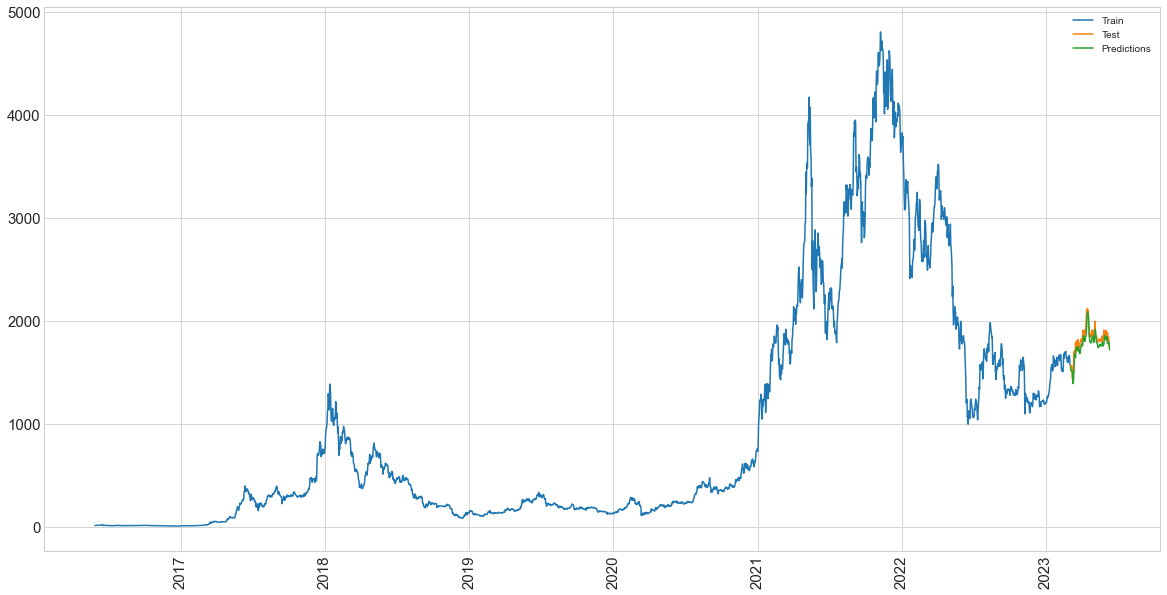

In [34]:
for column in Y_TEST.columns:
    # Visualize the data
    plt.figure(figsize=(20,10))
    plt.plot(Y_TRAIN[column])
    plt.plot(Y_TEST[column])
    plt.plot(test_predictions[column])
    plt.legend(['Train', 'Test', 'Predictions'])
    plt.xticks(rotation=90)
    plt.show()

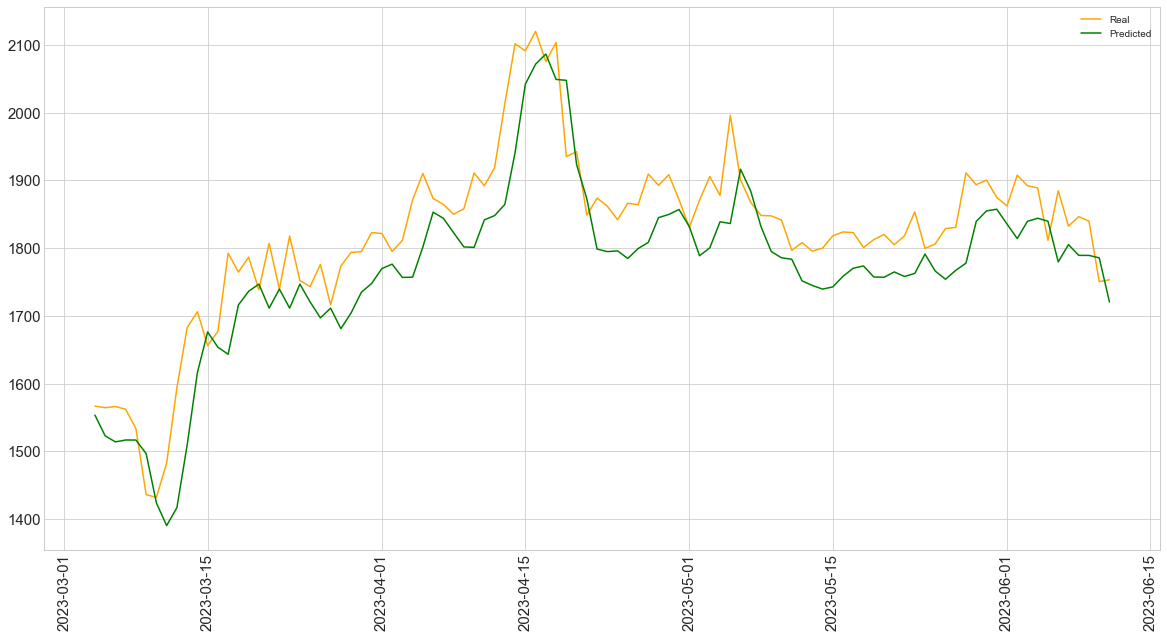

In [35]:
# visualize only the test set with the predictions part from the previous graph
plt.figure(figsize=(20,10))
plt.plot(Y_TEST, color='orange')
plt.plot(test_predictions, color='green')
plt.legend(['Real', 'Predicted'])
plt.xticks(rotation=90)
plt.show()

In [36]:
mse = mean_squared_error(Y_TEST, Y_PRED_T)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_TEST, Y_PRED_T)
avg_actual = np.mean(Y_TEST['Ethereum_Prices'])
mape = (mae / avg_actual) * 100
r2 = r2_score(Y_TEST, Y_PRED_T)

print('Modelo LSTM para o conjunto de teste - RMSE Error:', rmse)
print('Modelo LSTM para o conjunto de teste - MAE Error:', mae)
print('Modelo LSTM para o conjunto de teste - MAPE Error:', mape)
print('Modelo LSTM para o conjunto de teste - R_Squared:', r2)

Modelo LSTM para o conjunto de teste - RMSE Error: 70.61407630560163
Modelo LSTM para o conjunto de teste - MAE Error: 58.38431503906249
Modelo LSTM para o conjunto de teste - MAPE Error: 3.206816878971904
Modelo LSTM para o conjunto de teste - R_Squared: 0.6839379322067


#### Mod10: Gated Recurrent Unit (GRU) Neural Network

In [24]:
# Define the GRU model
model10 = Sequential()
model10.add(GRU(units=32, input_shape=(9, 1)))  # Adjust the units as needed
model10.add(Dense(units=1))  # Output layer with 1 unit for regression

# Compile the model
model10.compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss function as needed

# Print the model summary
model10.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                3360      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [25]:
gru_model = model10.fit(X_TRAIN,
                    Y_TRAIN_S,
                    batch_size=1, #will cycle through all samples
                    epochs=50, # maximum number of times the training algo= 1 # number of samples per mini-batch
                    verbose=0)

Epoch 1/50
2471/2471 [==============================] - 6s 2ms/step - loss: 0.0058
Epoch 2/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0036
Epoch 3/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0032
Epoch 4/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0028
Epoch 5/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0024
Epoch 6/50
2471/2471 [==============================] - 4s 2ms/step - loss: 0.0022
Epoch 7/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0021
Epoch 8/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0021
Epoch 9/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0019
Epoch 10/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0018
Epoch 11/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0017
Epoch 12/50
2471/2471 [==============================] - 5s 2ms/step - loss: 0.0016
E

###### In-sample predictions (train set predictions)

In [26]:
t_predictions2 = model10.predict(X_TRAIN)

78/78 [==============================] - 0s 1ms/step


In [27]:
X_PRED_T = scaler.inverse_transform(t_predictions2)

In [28]:
train_predictions_gru = pd.DataFrame(data= X_PRED_T, index=Y_TRAIN.index, columns=Y_TRAIN.columns)

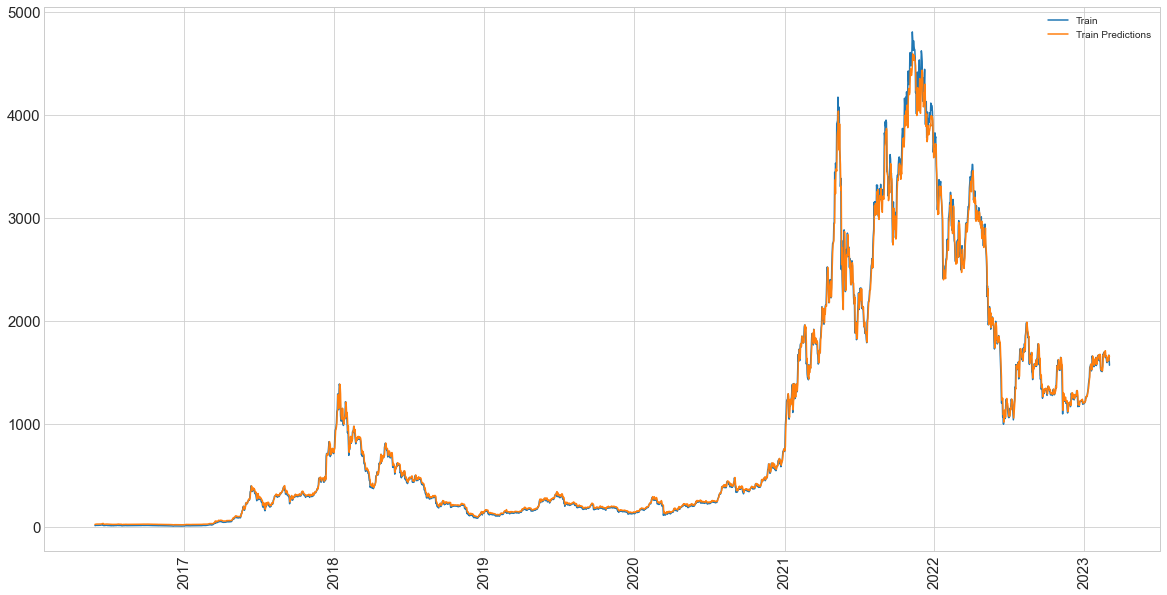

In [29]:
for column in Y_TRAIN.columns:
    # Get the train set data and corresponding predictions
    train_data = Y_TRAIN['Ethereum_Prices']
    train_predictions_data = train_predictions_gru['Ethereum_Prices']
    
    # Visualize the data
    plt.figure(figsize=(20,10))
    plt.plot(train_data)
    plt.plot(train_predictions_data)
    plt.legend(['Train', 'Train Predictions'])
    plt.xticks(rotation=90)
    plt.show()

In [37]:
mse = mean_squared_error(Y_TRAIN, X_PRED_T)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_TRAIN, X_PRED_T)
avg_actual = np.mean(Y_TRAIN['Ethereum_Prices'])
mape = (mae / avg_actual) * 100
r2 = r2_score(Y_TRAIN, X_PRED_T)

print('Modelo GRU para o conjunto de treino - RMSE Error:', rmse)
print('Modelo GRU para o conjunto de treino - MAE Error:', mae)
print('Modelo GRU para o conjunto de treino - MAPE Error:', mape)
print('Modelo GRU para o conjunto de treino - R_Squared:', r2)

Modelo GRU para o conjunto de treino - RMSE Error: 71.79249147119233
Modelo GRU para o conjunto de treino - MAE Error: 38.31759882292059
Modelo GRU para o conjunto de treino - MAPE Error: 4.164389325209024
Modelo GRU para o conjunto de treino - R_Squared: 0.995922066093743


###### Test set predictions

In [31]:
predictions = model10.predict(X_TEST)

4/4 [==============================] - 0s 2ms/step


In [32]:
Y_PRED_T = scaler.inverse_transform(predictions)

In [33]:
test_predictions = pd.DataFrame(data= Y_PRED_T, index=Y_TEST.index, columns=Y_TEST.columns)

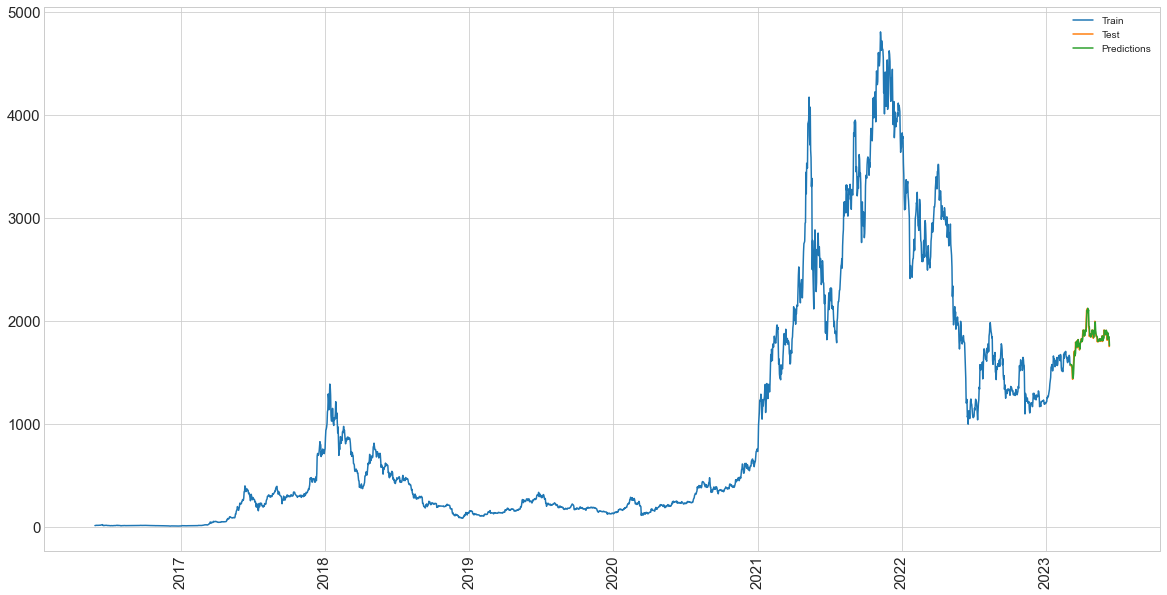

In [34]:
for column in Y_TEST.columns:
    # Visualize the data
    plt.figure(figsize=(20,10))
    plt.plot(Y_TRAIN[column])
    plt.plot(Y_TEST[column])
    plt.plot(test_predictions[column])
    plt.legend(['Train', 'Test', 'Predictions'])
    plt.xticks(rotation=90)
    plt.show()

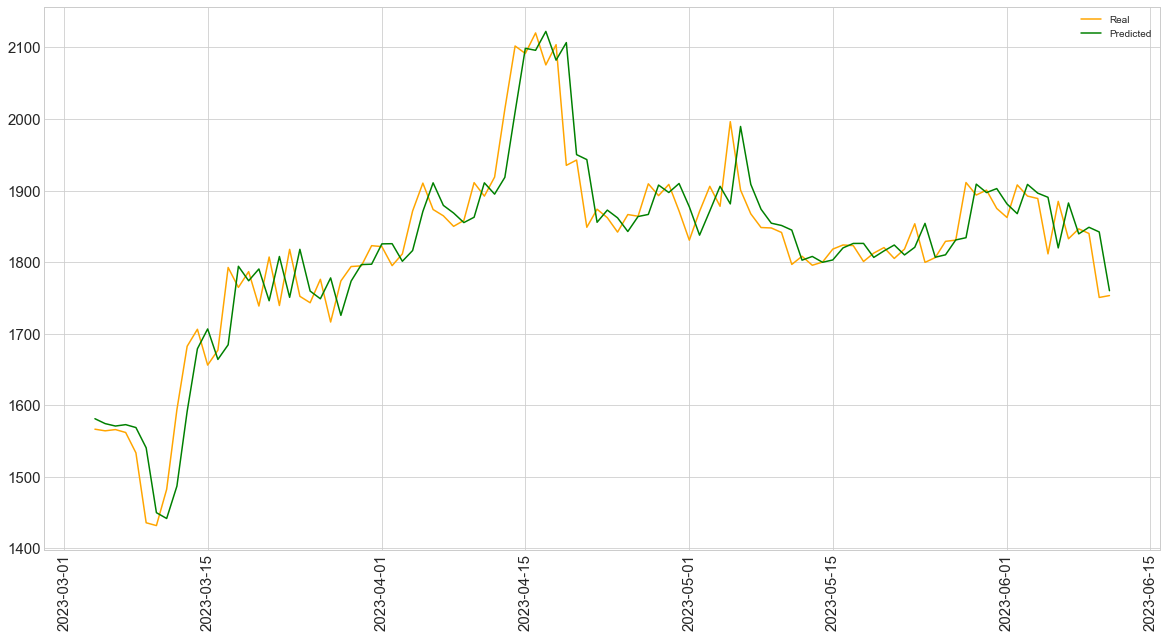

In [35]:
# visualize only the test set with the predictions part from the previous graph
plt.figure(figsize=(20,10))
plt.plot(Y_TEST, color='orange')
plt.plot(test_predictions, color='green')
plt.legend(['Real', 'Predicted'])
plt.xticks(rotation=90)
plt.show()

In [38]:
mse = mean_squared_error(Y_TEST, Y_PRED_T)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_TEST, Y_PRED_T)
avg_actual = np.mean(Y_TEST['Ethereum_Prices'])
mape = (mae / avg_actual) * 100
r2 = r2_score(Y_TEST, Y_PRED_T)

print('Modelo GRU para o conjunto de teste - RMSE Error:', rmse)
print('Modelo GRU para o conjunto de teste - MAE Error:', mae)
print('Modelo GRU para o conjunto de teste - MAPE Error:', mape)
print('Modelo GRU para o conjunto de teste - R_Squared:', r2)

Modelo GRU para o conjunto de teste - RMSE Error: 47.084887440357164
Modelo GRU para o conjunto de teste - MAE Error: 34.40307778320312
Modelo GRU para o conjunto de teste - MAPE Error: 1.889623445097295
Modelo GRU para o conjunto de teste - R_Squared: 0.8594752293615292
